In [1]:
import os
import warnings
from typing import Dict, List, Tuple, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 140)
warnings.filterwarnings('ignore')

DATA_PATH = "data/IBM_HR.csv"

def h(title: str):
    print("\n" + "=" * 12 + f" {title} " + "=" * 12)

In [2]:
# ===== 1) Load data =====
h("LOAD DATA")
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"File not found: {DATA_PATH}")
df = pd.read_csv(DATA_PATH)
print(f"Loaded shape: {df.shape}")
print("Columns:", list(df.columns)[:10], ("... (truncated)" if df.shape[1] > 10 else ""))

# ===== 2) Basic structure =====
h("BASIC INFO")
print(df.head(3))
print("\nData types:")
print(df.dtypes)

h("INFO()")
df.info()

# ===== 3) Missing values & duplicates =====
h("MISSING VALUES")
missing = df.isna().sum().sort_values(ascending=False)
print(missing[missing > 0] if (missing > 0).any() else "No missing values detected.")

h("DUPLICATES")
dup_count = df.duplicated().sum()
print(f"Duplicate rows: {dup_count}")

# Optional: visualize missingness (only if any)
if (missing > 0).any():
    plt.figure()
    missing[missing > 0].plot(kind="bar")
    plt.title("Missing values per column")
    plt.xlabel("Column")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# ===== 4) Split numeric / categorical =====
h("COLUMN GROUPS")
num_cols: List[str] = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols: List[str] = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
print(f"Numeric columns ({len(num_cols)}):", num_cols[:15], ("... (truncated)" if len(num_cols) > 15 else ""))
print(f"Categorical columns ({len(cat_cols)}):", cat_cols[:15], ("... (truncated)" if len(cat_cols) > 15 else ""))

# ===== 5) Descriptive statistics =====
h("DESCRIPTIVE STATS — NUMERIC")
if len(num_cols) > 0:
    display(df[num_cols].describe().T)
else:
    print("No numeric columns.")

h("CARDINALITY — CATEGORICAL")
if len(cat_cols) > 0:
    card = df[cat_cols].nunique().sort_values(ascending=False)
    display(card.to_frame("n_unique"))
else:
    print("No categorical columns.")

# ===== 6) Target detection (optional convenience) =====
# If a likely target exists (e.g., Attrition/label/target), show balance.
h("TARGET CANDIDATES")
target_candidates = ["Attrition", "target", "Target", "label", "Label"]
target_col = next((c for c in target_candidates if c in df.columns), None)
print(f"Detected target: {target_col}" if target_col else "No obvious target column detected.")
if target_col:
    vc = df[target_col].value_counts(dropna=False)
    vcp = df[target_col].value_counts(normalize=True, dropna=False).mul(100).round(2)
    print("\nClass balance (counts):")
    print(vc)
    print("\nClass balance (percent):")
    print(vcp.astype(str) + "%")

# ===== 7) Correlation (numeric) =====
h("CORRELATION (NUMERIC)")
corr_cols = num_cols.copy()

# Try mapping a binary/object target to numeric for correlation if present
if target_col:
    tmp = df[target_col]
    mapped = None
    if tmp.dtype == "object":
        lower = set(str(v).lower() for v in tmp.dropna().unique())
        if lower.issubset({"yes", "no"}):
            mapped = tmp.map({"Yes": 1, "No": 0, "yes": 1, "no": 0})
        elif lower.issubset({"true", "false"}):
            mapped = tmp.map({"True": 1, "False": 0, "true": 1, "false": 0})
        else:
            # Fallback: factorize non-ordered labels to integers
            mapped = pd.Series(pd.factorize(tmp)[0], index=tmp.index)
    elif pd.api.types.is_bool_dtype(tmp):
        mapped = tmp.astype(int)
    elif pd.api.types.is_numeric_dtype(tmp):
        mapped = tmp.astype(float)

    if mapped is not None:
        df["_target_num"] = mapped
        corr_cols = corr_cols + ["_target_num"]

if len(corr_cols) >= 2:
    corr = df[corr_cols].corr(numeric_only=True)
    # Heatmap with matplotlib (no seaborn, single-figure)
    fig, ax = plt.subplots(figsize=(max(6, 0.45 * len(corr_cols)), max(4, 0.45 * len(corr_cols))))
    im = ax.imshow(corr.values, interpolation="nearest")
    ax.set_xticks(range(len(corr_cols)))
    ax.set_yticks(range(len(corr_cols)))
    ax.set_xticklabels(corr_cols, rotation=90)
    ax.set_yticklabels(corr_cols)
    ax.set_title("Correlation matrix")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns to compute correlation.")

# ===== 8) Quick univariate visuals (lightweight defaults) =====
def plot_numeric_distributions(df_in: pd.DataFrame, cols: List[str], n: int = 4, bins: int = 30) -> None:
    """Plot simple histograms for the first n numeric features. One figure per feature."""
    for c in cols[: max(0, n)]:
        plt.figure()
        df_in[c].dropna().hist(bins=bins)
        plt.title(f"Distribution: {c}")
        plt.xlabel(c)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

def plot_categorical_counts(df_in: pd.DataFrame, cols: List[str], n: int = 4, top: int = 10) -> None:
    """Plot simple bar charts for the first n categorical features (top-k levels). One figure per feature."""
    for c in cols[: max(0, n)]:
        counts = df_in[c].astype(str).value_counts().head(top)
        plt.figure()
        counts.plot(kind="bar")
        plt.title(f"Counts: {c} (top {top})")
        plt.xlabel(c)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

h("QUICK PLOTS")
if len(num_cols) > 0:
    print("Numeric distributions (first up to 4 features):")
    plot_numeric_distributions(df, num_cols, n=min(4, len(num_cols)))
else:
    print("No numeric columns to plot.")

if len(cat_cols) > 0:
    print("Categorical counts (first up to 4 features):")
    plot_categorical_counts(df, cat_cols, n=min(4, len(cat_cols)), top=10)
else:
    print("No categorical columns to plot.")

# ===== 9) Outlier summary via IQR (numeric) =====
def iqr_outlier_summary(df_in: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    """Return a table with outlier counts per numeric feature using 1.5*IQR rule."""
    rows = []
    for c in cols:
        s = df_in[c].dropna()
        if s.empty:
            rows.append((c, 0))
            continue
        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3 - q1
        lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        outliers = ((s < lower) | (s > upper)).sum()
        rows.append((c, int(outliers)))
    return pd.DataFrame(rows, columns=["feature", "outlier_count"]).sort_values("outlier_count", ascending=False)

h("OUTLIER SUMMARY (IQR)")
if len(num_cols) > 0:
    outlier_table = iqr_outlier_summary(df, num_cols)
    display(outlier_table.head(12))
else:
    print("No numeric columns for outlier summary.")

# Cleanup helper column if created
if "_target_num" in df.columns:
    df.drop(columns=["_target_num"], inplace=True)



============ LOAD DATA ============


FileNotFoundError: File not found: data/IBM_HR.csv

In [ ]:
# ===== Setup after base EDA: drop columns, split nominal/ordinal, cast/mapping, helpers =====
h("SETUP — DROP & SPLIT")

# 0) Guard
if "df" not in globals():
    raise RuntimeError("Run Cell 2 first to create `df`.")

# 1) Columns to drop (IDs / constants)
DROP_COLS = ["EmployeeCount", "EmployeeNumber", "Over18", "StandardHours"]
drop_present = [c for c in DROP_COLS if c in df.columns]
df = df.drop(columns=drop_present)
print(f"Dropped columns: {drop_present}")

# 2) Target and numeric mapping for later stats
TARGET = "Attrition"
if TARGET not in df.columns:
    raise ValueError(f"Target column '{TARGET}' not found in data.")
t = df[TARGET]
if t.dtype == "object":
    lower = set(str(v).lower() for v in t.dropna().unique())
    if lower.issubset({"yes", "no"}):
        df["_target_num"] = t.map({"Yes": 1, "No": 0, "yes": 1, "no": 0})
    else:
        df["_target_num"] = pd.Series(pd.factorize(t)[0], index=t.index)
elif pd.api.types.is_bool_dtype(t):
    df["_target_num"] = t.astype(int)
elif pd.api.types.is_numeric_dtype(t):
    df["_target_num"] = t.astype(float)
else:
    df["_target_num"] = pd.Series(pd.factorize(t)[0], index=t.index)

# 3) Ordinal maps (ordered categorical)
ORDINAL_MAPS = {
    "Education": {1: "Below College", 2: "College", 3: "Bachelor", 4: "Master", 5: "Doctor"},
    "JobLevel": {1: "Entry", 2: "Junior", 3: "Mid", 4: "Senior", 5: "Executive"},
    "JobInvolvement": {1: "Low", 2: "Medium", 3: "High", 4: "Very High"},
    "JobSatisfaction": {1: "Low", 2: "Medium", 3: "High", 4: "Very High"},
    "EnvironmentSatisfaction": {1: "Low", 2: "Medium", 3: "High", 4: "Very High"},
    "RelationshipSatisfaction": {1: "Low", 2: "Medium", 3: "High", 4: "Very High"},
    "WorkLifeBalance": {1: "Bad", 2: "Good", 3: "Better", 4: "Best"},
    "PerformanceRating": {1: "Low", 2: "Good", 3: "Excellent", 4: "Outstanding"},
    "StockOptionLevel": {0: "None", 1: "Level 1", 2: "Level 2", 3: "Level 3"},
}

# 4) Nominal (unordered) columns (present in IBM HR)
NOMINAL_COLS_DEFINED = [
    "BusinessTravel", "Department", "EducationField", "Gender",
    "JobRole", "MaritalStatus", "OverTime"
]

# 5) Build lists actually present in df
ORDINAL_COLS = [c for c in ORDINAL_MAPS.keys() if c in df.columns]
NOMINAL_COLS = [c for c in NOMINAL_COLS_DEFINED if c in df.columns]

print(f"Ordinal cols (present): {ORDINAL_COLS}")
print(f"Nominal cols (present): {NOMINAL_COLS}")

# 6) Cast/Map: nominal -> category ; ordinal -> mapped ordered category
for c in NOMINAL_COLS:
    df[c] = df[c].astype("category")

for c in ORDINAL_COLS:
    m = ORDINAL_MAPS[c]
    keys_present = [k for k in m.keys() if k in set(df[c].dropna().unique())]
    keys_used = keys_present if len(keys_present) > 0 else list(m.keys())
    ordered_categories = [m[k] for k in sorted(keys_used)]
    df[c] = df[c].map(m)
    df[c] = pd.Categorical(df[c], categories=ordered_categories, ordered=True)

# 7) Helpers
def value_counts_table(df_in: pd.DataFrame, col: str, normalize: bool = True, top: int = None) -> pd.DataFrame:
    """Return value counts table with optional normalization."""
    vc = df_in[col].value_counts(normalize=normalize, dropna=False)
    if top is not None:
        vc = vc.head(top)
    out = vc.mul(100 if normalize else 1).round(2).to_frame("pct" if normalize else "count")
    out["count"] = df_in[col].value_counts(dropna=False).reindex(out.index).fillna(0).astype(int)
    return out

def attrition_rate_by_category(df_in: pd.DataFrame, cat_col: str, target_num: str = "_target_num") -> pd.DataFrame:
    """Compute attrition rate (%) per category."""
    tb = (
        df_in.groupby(cat_col)[target_num]
        .agg(["count", "mean"])
        .rename(columns={"mean": "attrition_rate"})
        .reset_index()
    )
    tb["attrition_rate"] = (tb["attrition_rate"] * 100).round(2)
    # Keep defined order for ordered categoricals
    if isinstance(df_in[cat_col].dtype, pd.CategoricalDtype) and df_in[cat_col].dtype.ordered:
        tb = tb.sort_values(cat_col, key=lambda s: s.cat.codes)
    else:
        tb = tb.sort_values("attrition_rate", ascending=False)
    return tb

def plot_bar_series(series: pd.Series, title: str, xlabel: str, ylabel: str):
    """Simple bar plot: one figure per chart, matplotlib only, no specific colors."""
    plt.figure()
    series.plot(kind="bar")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()


============ SETUP — DROP & SPLIT ============
Dropped columns: ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours']
Ordinal cols (present): ['Education', 'JobLevel', 'JobInvolvement', 'JobSatisfaction', 'EnvironmentSatisfaction', 'RelationshipSatisfaction', 'WorkLifeBalance', 'PerformanceRating', 'StockOptionLevel']
Nominal cols (present): ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']



============ NOMINAL EDA ============
Nominal columns: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']


--- BusinessTravel ---
Distribution (%):
                     pct  count
BusinessTravel                 
Travel_Rarely      70.95   1043
Travel_Frequently  18.84    277
Non-Travel         10.20    150


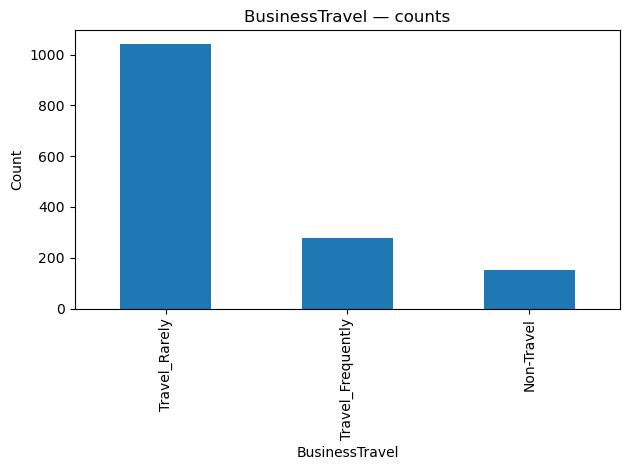


Attrition rate by category (%):
      BusinessTravel  count  attrition_rate
1  Travel_Frequently    277           24.91
2      Travel_Rarely   1043           14.96
0         Non-Travel    150            8.00


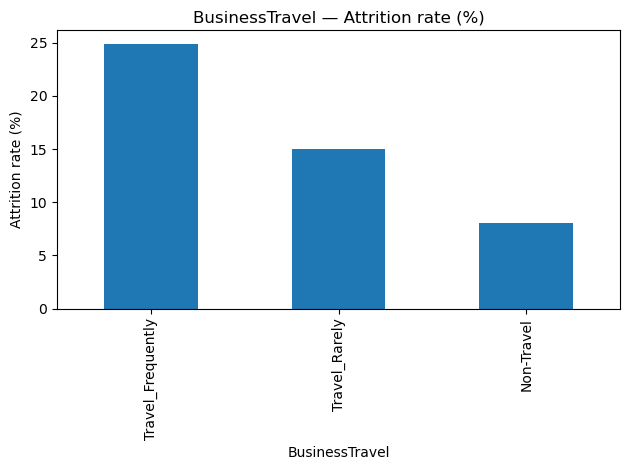


Chi-square: chi2=24.182, dof=2, p-value=5.609e-06

--- Department ---
Distribution (%):
                          pct  count
Department                          
Research & Development  65.37    961
Sales                   30.34    446
Human Resources          4.29     63


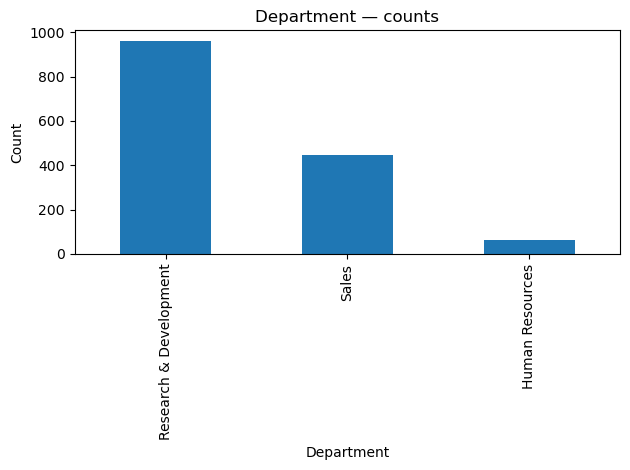


Attrition rate by category (%):
               Department  count  attrition_rate
2                   Sales    446           20.63
0         Human Resources     63           19.05
1  Research & Development    961           13.84


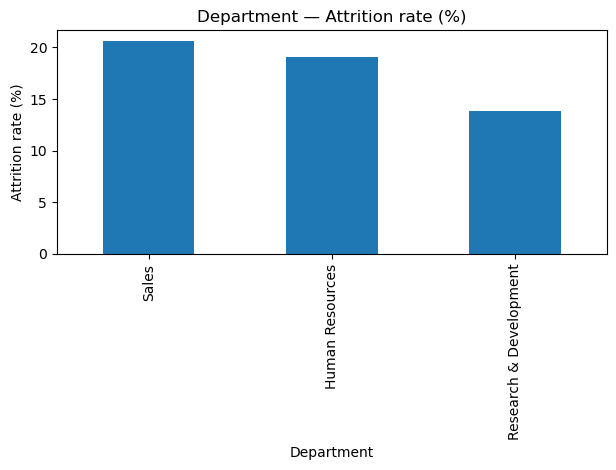


Chi-square: chi2=10.796, dof=2, p-value=0.004526

--- EducationField ---
Distribution (%):
                    pct  count
EducationField                
Life Sciences     41.22    606
Medical           31.56    464
Marketing         10.82    159
Technical Degree   8.98    132
Other              5.58     82
Human Resources    1.84     27


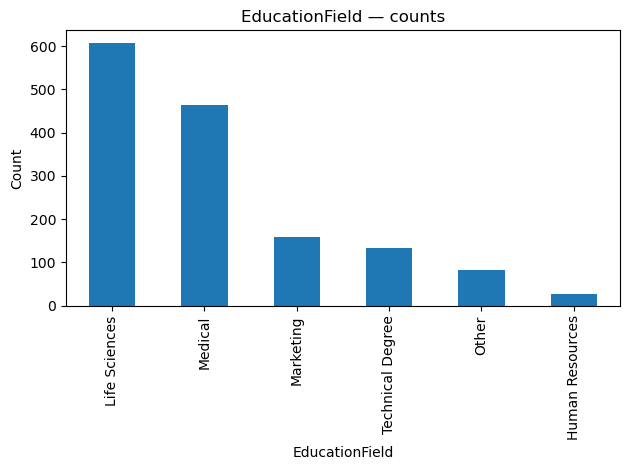


Attrition rate by category (%):
     EducationField  count  attrition_rate
0   Human Resources     27           25.93
5  Technical Degree    132           24.24
2         Marketing    159           22.01
1     Life Sciences    606           14.69
3           Medical    464           13.58
4             Other     82           13.41


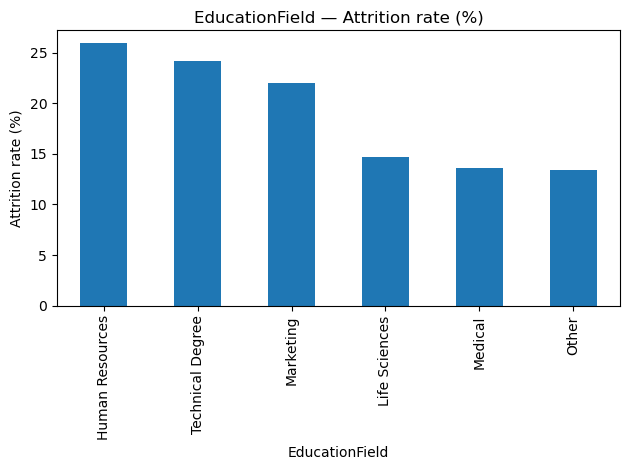


Chi-square: chi2=16.025, dof=5, p-value=0.006774

--- Gender ---
Distribution (%):
         pct  count
Gender             
Male    60.0    882
Female  40.0    588


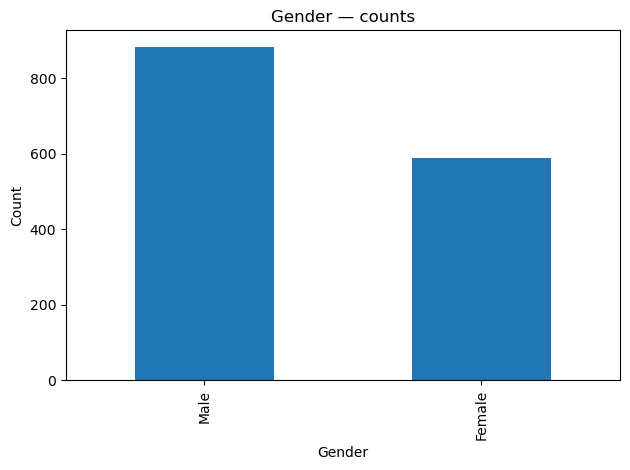


Attrition rate by category (%):
   Gender  count  attrition_rate
1    Male    882           17.01
0  Female    588           14.80


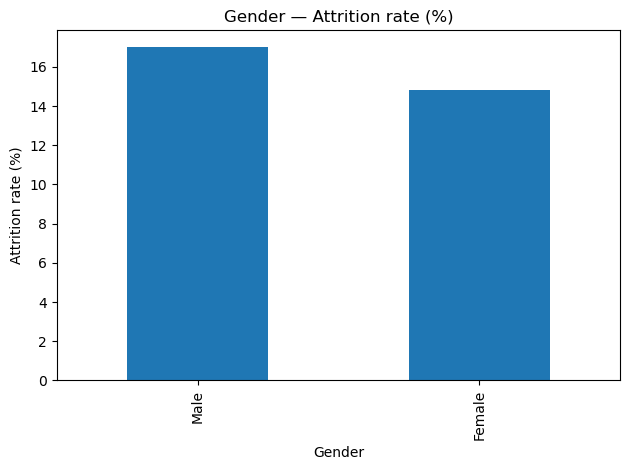


Chi-square: chi2=1.117, dof=1, p-value=0.2906

--- JobRole ---
Distribution (%):
                             pct  count
JobRole                                
Sales Executive            22.18    326
Research Scientist         19.86    292
Laboratory Technician      17.62    259
Manufacturing Director      9.86    145
Healthcare Representative   8.91    131
Manager                     6.94    102
Sales Representative        5.65     83
Research Director           5.44     80
Human Resources             3.54     52


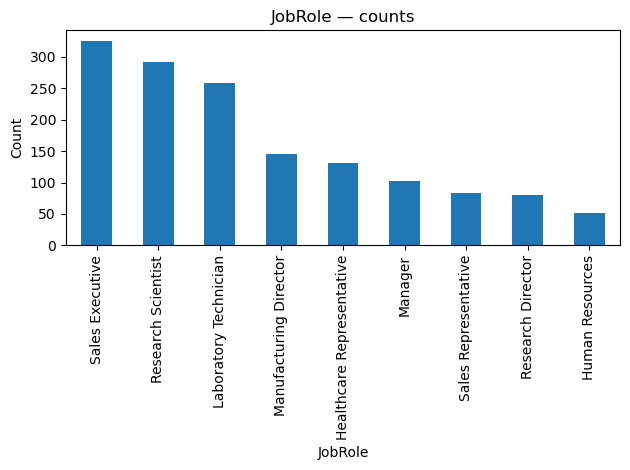


Attrition rate by category (%):
                     JobRole  count  attrition_rate
8       Sales Representative     83           39.76
2      Laboratory Technician    259           23.94
1            Human Resources     52           23.08
7            Sales Executive    326           17.48
6         Research Scientist    292           16.10
4     Manufacturing Director    145            6.90
0  Healthcare Representative    131            6.87
3                    Manager    102            4.90
5          Research Director     80            2.50


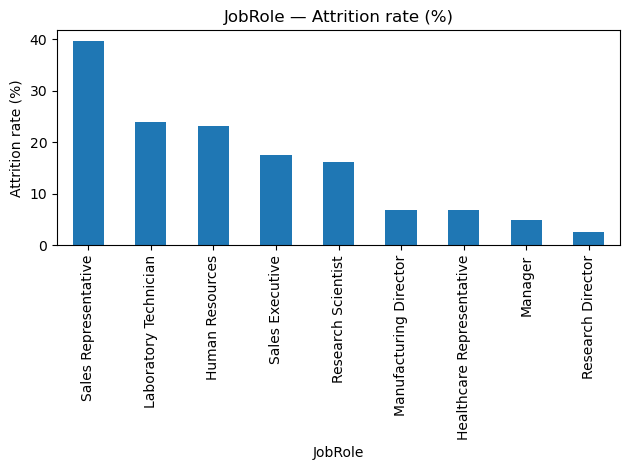


Chi-square: chi2=86.190, dof=8, p-value=2.752e-15

--- MaritalStatus ---
Distribution (%):
                 pct  count
MaritalStatus              
Married        45.78    673
Single         31.97    470
Divorced       22.24    327


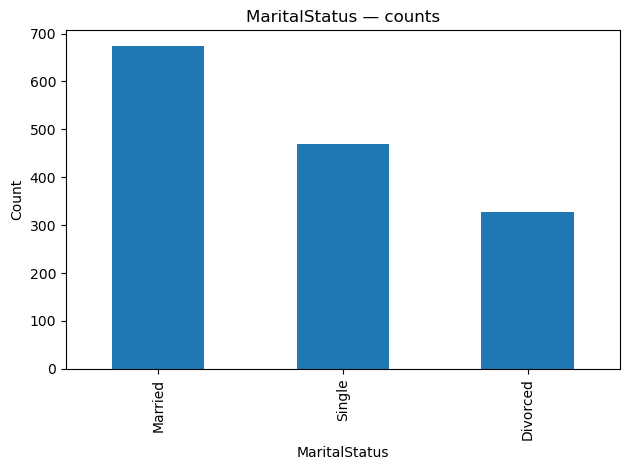


Attrition rate by category (%):
  MaritalStatus  count  attrition_rate
2        Single    470           25.53
1       Married    673           12.48
0      Divorced    327           10.09


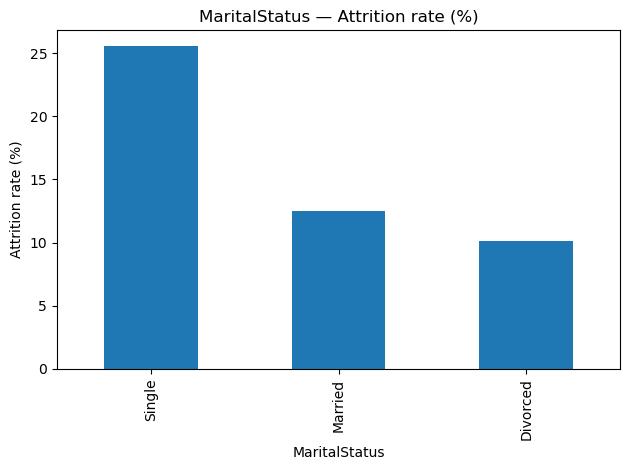


Chi-square: chi2=46.164, dof=2, p-value=9.456e-11

--- OverTime ---
Distribution (%):
           pct  count
OverTime             
No        71.7   1054
Yes       28.3    416


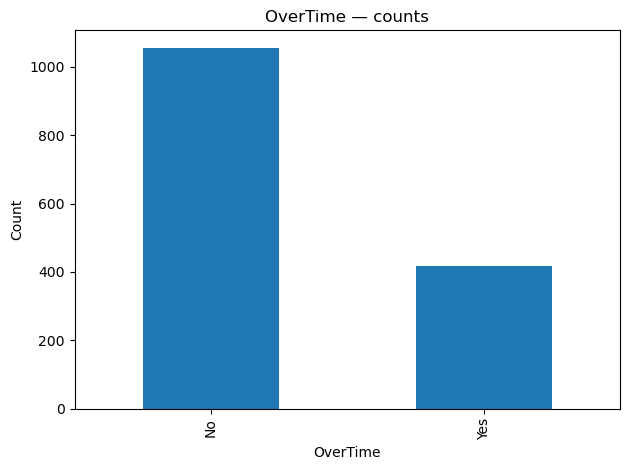


Attrition rate by category (%):
  OverTime  count  attrition_rate
1      Yes    416           30.53
0       No   1054           10.44


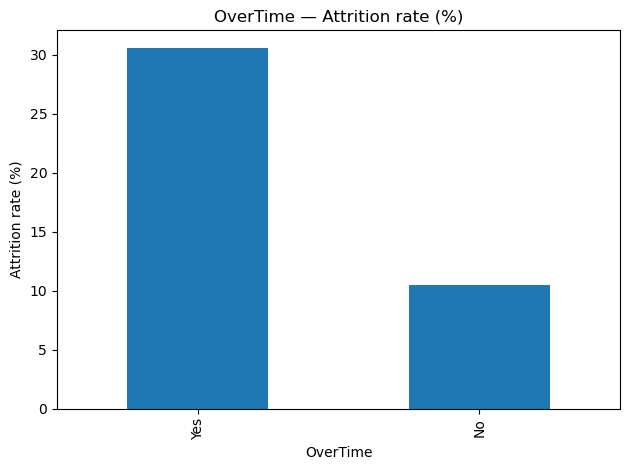


Chi-square: chi2=87.564, dof=1, p-value=8.158e-21


In [ ]:
# ===== Nominal EDA: distribution, attrition rate, chi-square (optional) =====
h("NOMINAL EDA")

# Optional chi-square via scipy
try:
    from scipy.stats import chi2_contingency
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

print(f"Nominal columns: {NOMINAL_COLS}\n")

for col in NOMINAL_COLS:
    print(f"\n--- {col} ---")
    # 1) Distribution
    dist = value_counts_table(df, col, normalize=True)
    print("Distribution (%):")
    print(dist)

    # Plot counts
    plot_bar_series(dist["count"], title=f"{col} — counts", xlabel=col, ylabel="Count")

    # 2) Attrition rate by category
    rate_tb = attrition_rate_by_category(df, col, "_target_num")
    print("\nAttrition rate by category (%):")
    print(rate_tb)

    # Plot attrition rate
    rate_series = rate_tb.set_index(col)["attrition_rate"]
    plot_bar_series(rate_series, title=f"{col} — Attrition rate (%)", xlabel=col, ylabel="Attrition rate (%)")

    # 3) Association test (Chi-square)
    if SCIPY_AVAILABLE:
        ct = pd.crosstab(df[col], df[TARGET])  # categories x {No, Yes}
        chi2, p, dof, exp = chi2_contingency(ct)
        print(f"\nChi-square: chi2={chi2:.3f}, dof={dof}, p-value={p:.4g}")
    else:
        print("\n[Note] SciPy not installed — skipping chi-square test.")


Numeric EDA: correlation (vs Attrition) + group stats + effect size


============ NUMERIC EDA — Attrition correlation & stats ============
Numeric features (14): ['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

============ NUMERIC EDA — TABLE (sorted by |Cohen's d|) ============


,feature,n_No,n_Yes,mean_No,std_No,median_No,mean_Yes,std_Yes,median_Yes,mean_diff(Yes-No),cohen_d,pearson_r,pearson_p,spearman_r,spearman_p,welch_t_p,levene_p
0,TotalWorkingYears,1233,237,11.863,7.761,10.0,8.245,7.169,7.0,-3.618,-0.472,-0.171,4.061878e-11,-0.199,1.355298e-14,1.159817e-11,0.080333
1,YearsInCurrentRole,1233,237,4.484,3.649,3.0,2.903,3.175,2.0,-1.581,-0.442,-0.161,6.003186e-10,-0.181,3.020683e-12,3.187390e-11,0.000066
2,MonthlyIncome,1233,237,6832.740,4818.208,5204.0,4787.093,3640.210,3202.0,-2045.647,-0.440,-0.160,7.147364e-10,-0.198,1.680405e-14,4.433589e-13,0.000118
3,Age,1233,237,37.561,8.888,36.0,33.608,9.689,32.0,-3.954,-0.438,-0.159,8.356308e-10,-0.171,3.902991e-11,1.379760e-08,0.484999
4,YearsWithCurrManager,1233,237,4.367,3.594,3.0,2.852,3.143,2.0,-1.515,-0.430,-0.156,1.736987e-09,-0.175,1.287671e-11,1.185022e-10,0.001918
5,YearsAtCompany,1233,237,7.369,6.096,6.0,5.131,5.950,3.0,-2.238,-0.369,-0.134,2.318872e-07,-0.190,1.811379e-13,2.285905e-07,0.097262
6,DistanceFromHome,1233,237,8.916,8.013,7.0,10.633,8.453,9.0,1.717,0.212,0.078,2.793060e-03,0.079,2.360919e-03,4.136512e-03,0.048086
7,TrainingTimesLastYear,1233,237,2.833,1.294,3.0,2.624,1.255,2.0,-0.208,-0.162,-0.059,2.257850e-02,-0.052,4.725061e-02,2.036379e-02,0.982317
8,DailyRate,1233,237,812.504,403.208,817.0,750.363,401.900,699.0,-62.142,-0.154,-0.057,2.985816e-02,-0.057,2.894999e-02,3.003954e-02,0.711297
9,NumCompaniesWorked,1233,237,2.646,2.460,2.0,2.941,2.679,1.0,0.295,0.118,0.043,9.552526e-02,0.031,2.424615e-01,1.163340e-01,0.069433



============ NUMERIC EDA — BOXPLOTS (top-6 by |d|) ============


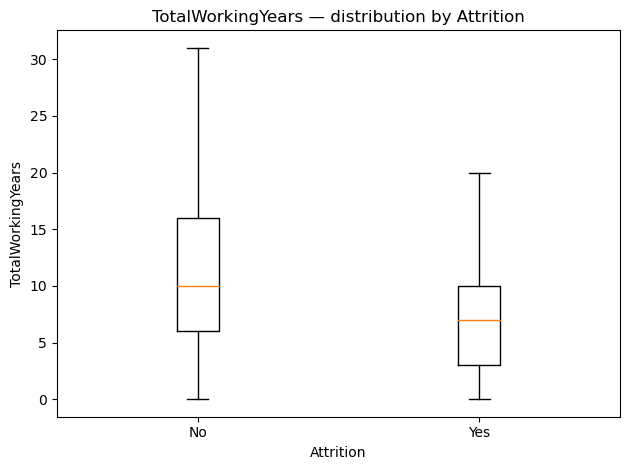

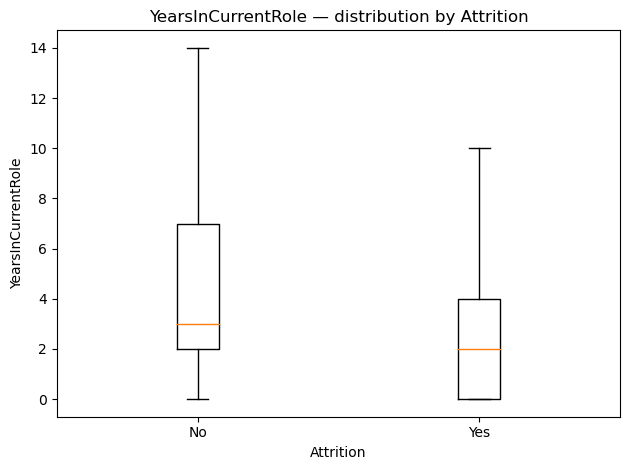

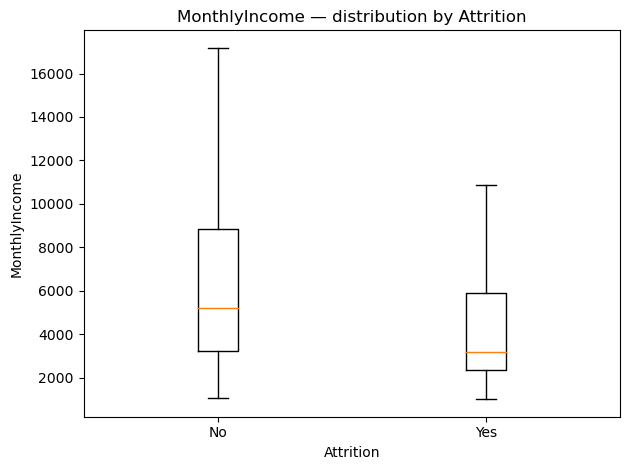

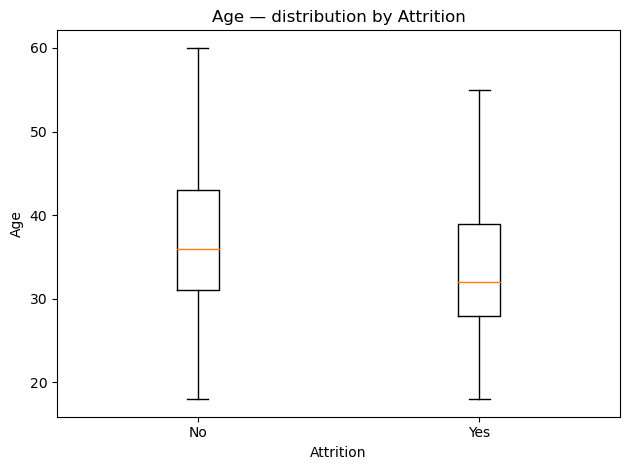

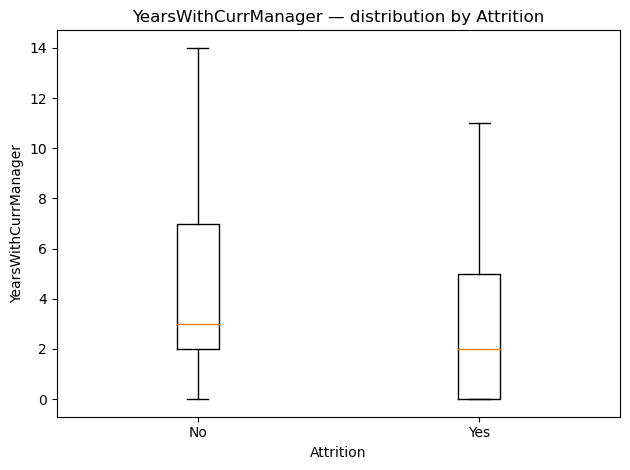

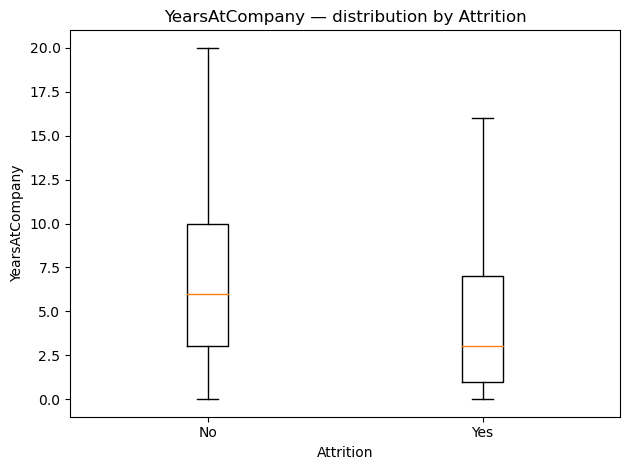

Saved: numeric_eda_attrition.csv


In [ ]:
# ===== Numeric EDA: correlations vs Attrition, group stats, effect size =====
h("NUMERIC EDA — Attrition correlation & stats")

# 0) Guards
if "df" not in globals():
    raise RuntimeError("Run previous cells to create `df` first.")
TARGET = "Attrition"
if TARGET not in df.columns:
    raise ValueError(f"Target column '{TARGET}' not found in df.")

# 1) Ensure binary numeric target (_target_num) for correlations
if "_target_num" not in df.columns:
    t = df[TARGET]
    if t.dtype == "object":
        lower = set(str(v).lower() for v in t.dropna().unique())
        if lower.issubset({"yes", "no"}):
            df["_target_num"] = t.map({"Yes": 1, "No": 0, "yes": 1, "no": 0})
        else:
            df["_target_num"] = pd.Series(pd.factorize(t)[0], index=t.index)
    elif pd.api.types.is_bool_dtype(t):
        df["_target_num"] = t.astype(int)
    elif pd.api.types.is_numeric_dtype(t):
        df["_target_num"] = t.astype(float)
    else:
        df["_target_num"] = pd.Series(pd.factorize(t)[0], index=t.index)

# 2) Define numeric features (exclude helper / IDs / ordinal-coded if still numeric)
DROP_IF_PRESENT = {"EmployeeCount", "EmployeeNumber", "Over18", "StandardHours", "_target_num"}
ORDINAL_NAMES = {
    "Education", "JobLevel", "JobInvolvement", "JobSatisfaction",
    "EnvironmentSatisfaction", "RelationshipSatisfaction",
    "WorkLifeBalance", "PerformanceRating", "StockOptionLevel",
}
all_num = df.select_dtypes(include=[np.number]).columns.tolist()
num_features = [
    c for c in all_num
    if c not in DROP_IF_PRESENT
    and c not in ORDINAL_NAMES  # in case user hasn't converted to category yet
]
num_features = sorted(num_features)
print(f"Numeric features ({len(num_features)}): {num_features}")

# 3) Stats helpers
def cohen_d(x: pd.Series, y: pd.Series) -> float:
    """Cohen's d using pooled SD."""
    x = pd.to_numeric(x, errors="coerce").dropna()
    y = pd.to_numeric(y, errors="coerce").dropna()
    if len(x) < 2 or len(y) < 2:
        return np.nan
    nx, ny = len(x), len(y)
    sx, sy = x.std(ddof=1), y.std(ddof=1)
    if (nx + ny - 2) <= 0:
        return np.nan
    sp = np.sqrt(((nx - 1) * sx**2 + (ny - 1) * sy**2) / (nx + ny - 2))
    if sp == 0 or np.isnan(sp):
        return np.nan
    return (x.mean() - y.mean()) / sp

# Optional hypothesis tests via SciPy
try:
    from scipy.stats import ttest_ind, spearmanr, pearsonr, levene
    SCIPY = True
except Exception:
    SCIPY = False

# 4) Build per-feature table: group stats, mean diff, Cohen's d, Pearson/Spearman vs target
rows = []
g1 = df["_target_num"] == 1  # Attrition=Yes
g0 = df["_target_num"] == 0  # Attrition=No

for col in num_features:
    s0 = pd.to_numeric(df.loc[g0, col], errors="coerce").dropna()
    s1 = pd.to_numeric(df.loc[g1, col], errors="coerce").dropna()

    n0, n1 = len(s0), len(s1)
    mean0, mean1 = s0.mean(), s1.mean()
    std0, std1 = s0.std(ddof=1), s1.std(ddof=1)
    med0, med1 = s0.median(), s1.median()

    mdiff = mean1 - mean0  # (Yes - No)
    d = cohen_d(s1, s0)    # effect size (Yes vs No)

    # Correlations with binary target (point-biserial == Pearson with 0/1)
    pr, pr_p = (np.nan, np.nan)
    sr, sr_p = (np.nan, np.nan)
    if SCIPY:
        # Pearson
        xx = pd.to_numeric(df[col], errors="coerce")
        yy = df["_target_num"].astype(float)
        valid = (~xx.isna()) & (~yy.isna())
        if valid.sum() > 2:
            try:
                pr, pr_p = pearsonr(xx[valid], yy[valid])
            except Exception:
                pr, pr_p = (xx[valid].corr(yy[valid], method="pearson"), np.nan)
            try:
                sr, sr_p = spearmanr(xx[valid], yy[valid])
            except Exception:
                sr, sr_p = (xx[valid].corr(yy[valid], method="spearman"), np.nan)
        # Welch's t-test (unequal variances)
        try:
            # Levene test for variance difference (optional)
            _, p_levene = levene(s0, s1) if (n0 > 1 and n1 > 1) else (np.nan, np.nan)
            _, p_t = ttest_ind(s1, s0, equal_var=False, alternative="two-sided")
        except Exception:
            p_levene, p_t = (np.nan, np.nan)
    else:
        # Fallback: correlations without p-values
        xx = pd.to_numeric(df[col], errors="coerce")
        yy = df["_target_num"].astype(float)
        valid = (~xx.isna()) & (~yy.isna())
        pr = xx[valid].corr(yy[valid], method="pearson")
        sr = xx[valid].corr(yy[valid], method="spearman")
        p_levene, p_t = (np.nan, np.nan)

    rows.append({
        "feature": col,
        "n_No": n0, "n_Yes": n1,
        "mean_No": round(mean0, 3), "std_No": round(std0, 3), "median_No": round(med0, 3),
        "mean_Yes": round(mean1, 3), "std_Yes": round(std1, 3), "median_Yes": round(med1, 3),
        "mean_diff(Yes-No)": round(mdiff, 3),
        "cohen_d": round(d, 3),
        "pearson_r": round(pr, 3) if pd.notna(pr) else np.nan,
        "pearson_p": pr_p if pd.notna(pr) else np.nan,
        "spearman_r": round(sr, 3) if pd.notna(sr) else np.nan,
        "spearman_p": sr_p if pd.notna(sr) else np.nan,
        "welch_t_p": p_t if SCIPY else np.nan,
        "levene_p": p_levene if SCIPY else np.nan,
    })

num_eda_tbl = pd.DataFrame(rows).sort_values(by="cohen_d", key=lambda s: s.abs(), ascending=False).reset_index(drop=True)

h("NUMERIC EDA — TABLE (sorted by |Cohen's d|)")
display(num_eda_tbl.head(20))

# 5) Quick visuals: top-6 by |Cohen's d| (boxplots)
h("NUMERIC EDA — BOXPLOTS (top-6 by |d|)")
top_feats = num_eda_tbl["feature"].head(6).tolist()
for col in top_feats:
    plt.figure()
    # build two boxes: No (0) and Yes (1)
    data_no = pd.to_numeric(df.loc[g0, col], errors="coerce").dropna()
    data_yes = pd.to_numeric(df.loc[g1, col], errors="coerce").dropna()
    plt.boxplot([data_no.values, data_yes.values], labels=["No", "Yes"], showfliers=False)
    plt.title(f"{col} — distribution by Attrition")
    plt.xlabel("Attrition")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# 6) (Optional) save table to CSV for reporting
OUT_CSV = "numeric_eda_attrition.csv"
num_eda_tbl.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
print(f"Saved: {OUT_CSV}")

Partial correlation & Adjusted logistic effects (per 1 SD)

In [ ]:
# ===== Partial correlation (via residualization) + Adjusted logistic effects =====
h("PARTIAL CORR & ADJUSTED LOGIT EFFECTS")

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Optional: p-values for correlations
try:
    from scipy.stats import pearsonr, spearmanr
    SCIPY = True
except Exception:
    SCIPY = False

# Guards
if "df" not in globals():
    raise RuntimeError("Run previous cells first to create `df`.")
if "_target_num" not in df.columns:
    # create numeric target from Attrition if missing
    t = df["Attrition"]
    if t.dtype == "object":
        lower = set(str(v).lower() for v in t.dropna().unique())
        if lower.issubset({"yes","no"}):
            df["_target_num"] = t.map({"Yes":1,"No":0,"yes":1,"no":0})
        else:
            df["_target_num"] = pd.Series(pd.factorize(t)[0], index=t.index)
    elif pd.api.types.is_bool_dtype(t):
        df["_target_num"] = t.astype(int)
    else:
        df["_target_num"] = pd.to_numeric(t, errors="coerce")

Y = "_target_num"   # binary 0/1

# === 1) Choose features to analyze and controls (edit as needed) ===
NUM_TO_CHECK = [
    "MonthlyIncome","TotalWorkingYears","YearsInCurrentRole",
    "Age","YearsWithCurrManager","DistanceFromHome","YearsAtCompany"
]

BASE_CONTROLS_NUM = [
    # Numeric controls used for all features (will be auto-removed if equals the feature)
    "YearsAtCompany"
]

BASE_CONTROLS_CAT = [
    # Categorical/ordinal controls (expanded as dummies with C())
    "JobLevel", "OverTime", "BusinessTravel", "MaritalStatus", "Department"
]

# Keep only those present in df
NUM_TO_CHECK = [c for c in NUM_TO_CHECK if c in df.columns]
BASE_CONTROLS_NUM = [c for c in BASE_CONTROLS_NUM if c in df.columns]
BASE_CONTROLS_CAT = [c for c in BASE_CONTROLS_CAT if c in df.columns]

print("Numeric features to check:", NUM_TO_CHECK)
print("Numeric controls:", BASE_CONTROLS_NUM)
print("Categorical controls:", BASE_CONTROLS_CAT)

# === 2) Helpers ===
def _formula_controls(x: str, num_controls: list, cat_controls: list) -> str:
    """Build RHS of formula: x + numeric controls + categorical controls as C(var)."""
    rhs_parts = [x]
    rhs_parts += num_controls
    rhs_parts += [f"C({c})" for c in cat_controls]
    rhs = " + ".join(rhs_parts) if rhs_parts else "1"
    return rhs

def partial_corr_resid(df_in: pd.DataFrame, y: str, x: str, num_controls: list, cat_controls: list):
    """
    Residualization-based partial correlation:
      1) y ~ controls  (OLS; linear probability model for binary y)
      2) x ~ controls  (OLS)
      3) corr(res_y, res_x)  (Pearson & Spearman)
    Returns: (pearson_r, pearson_p, spearman_r, spearman_p, n)
    """
    # Drop rows with NA in y/x/controls
    cols_needed = [y, x] + num_controls + cat_controls
    d = df_in[cols_needed].dropna().copy()
    if d.shape[0] < 20:   # too few rows
        return (np.nan, np.nan, np.nan, np.nan, d.shape[0])

    # Build formulas
    rhs = _formula_controls("1", num_controls, cat_controls)  # intercept already included by OLS
    # y residuals
    model_y = smf.ols(formula=f"{y} ~ {rhs}", data=d).fit()
    res_y = model_y.resid
    # x residuals
    model_x = smf.ols(formula=f"{x} ~ {rhs}", data=d).fit()
    res_x = model_x.resid

    # Correlations
    if SCIPY:
        pr, pp = pearsonr(res_x, res_y)
        sr, sp = spearmanr(res_x, res_y)
    else:
        pr = pd.Series(res_x).corr(pd.Series(res_y), method="pearson")
        sr = pd.Series(res_x).corr(pd.Series(res_y), method="spearman")
        pp = np.nan; sp = np.nan
    return (pr, pp, sr, sp, d.shape[0])

def logit_adjusted(df_in: pd.DataFrame, y: str, x: str, num_controls: list, cat_controls: list, standardize=True):
    """
    Adjusted logistic regression:
      - Fit: y ~ z(x) + controls, where z(x) = (x - mean)/std if standardize=True
      - Returns OR per +1 SD, 95% CI, p-value, and Average Marginal Effect (AME)
    """
    cols_needed = [y, x] + num_controls + cat_controls
    d = df_in[cols_needed].dropna().copy()
    if d.shape[0] < 20:
        return (np.nan, (np.nan, np.nan), np.nan, np.nan, d.shape[0])

    # Standardize x (per 1 SD) to make OR interpretable
    x_term = x
    if standardize:
        mu = d[x].mean()
        sd = d[x].std(ddof=0)
        if sd == 0 or np.isnan(sd):
            return (np.nan, (np.nan, np.nan), np.nan, np.nan, d.shape[0])
        d[f"z_{x}"] = (d[x] - mu) / sd
        x_term = f"z_{x}"

    rhs = _formula_controls(x_term, num_controls, cat_controls)
    formula = f"{y} ~ {rhs}"

    try:
        fit = smf.logit(formula=formula, data=d).fit(disp=0, maxiter=200)
        # Coef for x_term
        b = fit.params.get(x_term, np.nan)
        se = fit.bse.get(x_term, np.nan)
        p = fit.pvalues.get(x_term, np.nan)

        # Odds Ratio and 95% CI
        OR = np.exp(b) if pd.notna(b) else np.nan
        CI_low = np.exp(b - 1.96*se) if pd.notna(b) and pd.notna(se) else np.nan
        CI_high = np.exp(b + 1.96*se) if pd.notna(b) and pd.notna(se) else np.nan

        # Average Marginal Effect (dy/dx), overall
        try:
            ame_res = fit.get_margeff(at="overall").summary_frame()
            AME = float(ame_res.loc[x_term, "dy/dx"]) if x_term in ame_res.index else np.nan
        except Exception:
            AME = np.nan

        return (OR, (CI_low, CI_high), p, AME, d.shape[0])
    except Exception as e:
        print(f"[warn] logit failed for {x}: {e}")
        return (np.nan, (np.nan, np.nan), np.nan, np.nan, d.shape[0])

# === 3) Run for each numeric feature with the chosen controls ===
records = []
for x in NUM_TO_CHECK:
    # Avoid controlling by the variable itself if present in numeric controls
    num_ctrl = [c for c in BASE_CONTROLS_NUM if c != x]
    cat_ctrl = BASE_CONTROLS_CAT.copy()

    pr, pp, sr, sp, n_pc = partial_corr_resid(df, Y, x, num_ctrl, cat_ctrl)
    OR, (lo, hi), p_logit, AME, n_lg = logit_adjusted(df, Y, x, num_ctrl, cat_ctrl, standardize=True)

    records.append({
        "feature": x,
        "n_partial": n_pc,
        "partial_pearson_r": None if pd.isna(pr) else round(pr, 3),
        "partial_pearson_p": pp,
        "partial_spearman_r": None if pd.isna(sr) else round(sr, 3),
        "partial_spearman_p": sp,
        "n_logit": n_lg,
        "OR_per_1SD": None if pd.isna(OR) else round(OR, 3),
        "OR_95CI_low": lo,
        "OR_95CI_high": hi,
        "logit_p": p_logit,
        "AME(dy/dx)_per_1SD": AME
    })

result_partial_logit = pd.DataFrame(records).sort_values(by="OR_per_1SD", ascending=False)
h("RESULT — Partial corr & adjusted logit (per 1 SD)")
display(result_partial_logit)

# Save for report
OUT_CSV = "partial_corr_logit_results.csv"
result_partial_logit.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
print(f"Saved: {OUT_CSV}")


============ PARTIAL CORR & ADJUSTED LOGIT EFFECTS ============
Numeric features to check: ['MonthlyIncome', 'TotalWorkingYears', 'YearsInCurrentRole', 'Age', 'YearsWithCurrManager', 'DistanceFromHome', 'YearsAtCompany']
Numeric controls: ['YearsAtCompany']
Categorical controls: ['JobLevel', 'OverTime', 'BusinessTravel', 'MaritalStatus', 'Department']

============ RESULT — Partial corr & adjusted logit (per 1 SD) ============


,feature,n_partial,partial_pearson_r,partial_pearson_p,partial_spearman_r,partial_spearman_p,n_logit,OR_per_1SD,OR_95CI_low,OR_95CI_high,logit_p,AME(dy/dx)_per_1SD
5,DistanceFromHome,1470,0.096,0.000215,0.059,0.023536,1470,1.374,1.177756,1.603557,0.000054,0.034104
1,TotalWorkingYears,1470,-0.039,0.132878,-0.065,0.012622,1470,0.841,0.616763,1.147397,0.274946,-0.018812
6,YearsAtCompany,1470,-0.045,0.085011,-0.075,0.004223,1470,0.829,0.666331,1.030600,0.091206,-0.020479
3,Age,1470,-0.068,0.009527,-0.083,0.001387,1470,0.819,0.680252,0.986823,0.035749,-0.021607
4,YearsWithCurrManager,1470,-0.062,0.018261,-0.020,0.448154,1470,0.659,0.495314,0.877919,0.004348,-0.045049
2,YearsInCurrentRole,1470,-0.066,0.011097,-0.039,0.132016,1470,0.631,0.472449,0.842443,0.001796,-0.049776
0,MonthlyIncome,1470,-0.050,0.056843,-0.044,0.094868,1470,0.513,0.269623,0.975529,0.041798,-0.072471


Saved: partial_corr_logit_results.csv


Processing: drop (강권/유력/공선성) -> ColumnTransformer

In [ ]:
# ===== SPLIT → TREE-FRIENDLY PREP (no OHE, no SMOTE) → CV =====
h("SPLIT & TREE PREP (no One-Hot, no SMOTE) & CV — robust ordinal casting")

import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype, is_categorical_dtype
from sklearn.model_selection import train_test_split, StratifiedKFold

# Guards
if "df" not in globals():
    raise RuntimeError("Run previous cells first to create `df`.")
if "Attrition" not in df.columns:
    raise ValueError("Target 'Attrition' not found in df.")

# -------------------------------
# 1) Drop lists & target build
# -------------------------------
TARGET = "Attrition"
BASE_DROP = ["EmployeeCount", "EmployeeNumber", "Over18", "StandardHours"]
STRONGLY_DROP = ["DailyRate", "HourlyRate", "MonthlyRate"]
LIKELY_DROP   = ["PercentSalaryHike", "YearsSinceLastPromotion", "NumCompaniesWorked"]
KEEP_YEARS_AT_COMPANY = True
COLLINEAR_DROP = ["TotalWorkingYears"] if KEEP_YEARS_AT_COMPANY else ["YearsAtCompany"]
HELPER_DROP = ["_target_num", "_t", "_y", "_is_train"]

DROP_LIST = [c for c in (BASE_DROP + STRONGLY_DROP + LIKELY_DROP + COLLINEAR_DROP + HELPER_DROP) if c in df.columns]
print("Drop columns:", DROP_LIST)

Xdf = df.drop(columns=DROP_LIST, errors="ignore").copy()

# y (0/1)
y = Xdf[TARGET].map({"Yes": 1, "No": 0})
if y.isna().any():
    y = pd.Series(pd.factorize(Xdf[TARGET])[0], index=Xdf.index)
Xdf.drop(columns=[TARGET], inplace=True)

# -------------------------------
# 2) Column groups
# -------------------------------
ORDINAL_COLS_ALL = [
    "Education","JobLevel","JobInvolvement","JobSatisfaction",
    "EnvironmentSatisfaction","RelationshipSatisfaction","WorkLifeBalance",
    "PerformanceRating","StockOptionLevel"
]
NOMINAL_COLS_ALL = [
    "BusinessTravel","Department","EducationField","Gender",
    "JobRole","MaritalStatus","OverTime"
]

ordinal_cols = [c for c in ORDINAL_COLS_ALL if c in Xdf.columns]
nominal_cols = [c for c in NOMINAL_COLS_ALL if c in Xdf.columns]
# numeric: exclude ordinal & nominal first; we'll coerce ordinal to numeric next
numeric_cols = [c for c in Xdf.columns if (c not in ordinal_cols + nominal_cols) and is_numeric_dtype(Xdf[c])]

print(f"Numeric ({len(numeric_cols)}): {numeric_cols}")
print(f"Ordinal ({len(ordinal_cols)}): {ordinal_cols}")
print(f"Nominal ({len(nominal_cols)}): {nominal_cols}")

# -------------------------------
# 3) Robust: coerce ordinal columns to numeric codes (before imputation)
#    - if numeric → keep
#    - if category and ordered → use .cat.codes (NaNs stay as -1 then set NaN)
#    - if category/object with labels (e.g., 'Low','Medium',...) → map using label order
#    - if category with numeric-looking strings → to_numeric
# -------------------------------
ORDINAL_LABEL_ORDERS = {
    "JobInvolvement": ["Low","Medium","High","Very High"],
    "JobSatisfaction": ["Low","Medium","High","Very High"],
    "EnvironmentSatisfaction": ["Low","Medium","High","Very High"],
    "RelationshipSatisfaction": ["Low","Medium","High","Very High"],
    "WorkLifeBalance": ["Bad","Good","Better","Best"],
    "PerformanceRating": ["Low","Good","Excellent","Outstanding"],
    "Education": ["Below College","College","Bachelor","Master","Doctor"],
    "JobLevel": ["Entry","Junior","Mid","Senior","Executive"],
    "StockOptionLevel": ["None","Level 1","Level 2","Level 3"],
}

def _map_labels_to_codes(series: pd.Series, labels_in_order):
    s = series.astype(str).str.strip()
    # case-insensitive mapping
    mapping = {lab.lower(): code for code, lab in enumerate(labels_in_order, start=0 if labels_in_order[0]=="None" else 1)}
    return s.str.lower().map(mapping)

def coerce_ordinal_to_numeric(df_in: pd.DataFrame, cols):
    out = df_in.copy()
    for c in cols:
        s = out[c]
        if is_numeric_dtype(s):
            # already numeric; ensure float for safety
            out[c] = pd.to_numeric(s, errors="coerce")
            continue

        if is_categorical_dtype(s):
            # ordered categorical → codes; unordered try numeric-like, else label map, else codes
            if getattr(s.dtype, "ordered", False):
                codes = s.cat.codes.replace(-1, np.nan)
                out[c] = codes.astype(float)
                continue
            # unordered category: try numeric-like first
            try_num = pd.to_numeric(s.astype(str), errors="coerce")
            if try_num.notna().any():
                out[c] = try_num
                continue
            # try label mapping if known
            if c in ORDINAL_LABEL_ORDERS:
                mapped = _map_labels_to_codes(s, ORDINAL_LABEL_ORDERS[c])
                if mapped.notna().any():
                    out[c] = mapped.astype(float)
                    continue
            # fallback: categorical codes (order may be arbitrary)
            out[c] = s.cat.codes.replace(-1, np.nan).astype(float)
            continue

        # object/string labels
        try_num = pd.to_numeric(s, errors="coerce")
        if try_num.notna().any():
            out[c] = try_num
            continue
        if c in ORDINAL_LABEL_ORDERS:
            mapped = _map_labels_to_codes(s, ORDINAL_LABEL_ORDERS[c])
            out[c] = mapped.astype(float)
        else:
            # last resort: factorize (order arbitrary)
            codes, _ = pd.factorize(s, na_sentinel=-1)
            out[c] = pd.Series(codes, index=s.index).replace(-1, np.nan).astype(float)
    return out

# apply coercion to ordinal columns only
Xdf[ordinal_cols] = coerce_ordinal_to_numeric(Xdf[ordinal_cols], ordinal_cols)[ordinal_cols]

# -------------------------------
# 4) Minimal imputation (trees: no scaling needed)
#    - numeric & ordinal -> median
#    - nominal -> pandas 'category' + '__UNK__' for NA
# -------------------------------
for c in numeric_cols + ordinal_cols:
    # at this point, these should be numeric dtypes
    Xdf[c] = pd.to_numeric(Xdf[c], errors="coerce")
    Xdf[c] = Xdf[c].fillna(Xdf[c].median())

for c in nominal_cols:
    Xdf[c] = Xdf[c].astype("category")
    if "__UNK__" not in Xdf[c].cat.categories:
        Xdf[c] = Xdf[c].cat.add_categories(["__UNK__"])
    Xdf[c] = Xdf[c].fillna("__UNK__")

# -------------------------------
# 5) Train/Test split (7:3, stratified)
# -------------------------------
X_train_df, X_test_df, y_train, y_test = train_test_split(
    Xdf, y, test_size=0.30, stratify=y, random_state=42
)

print(f"\nSplit -> Train: {X_train_df.shape}, Test: {X_test_df.shape}")
print("Class balance (train):", y_train.value_counts(normalize=True).round(3).to_dict())
print("Class balance (test) :", y_test.value_counts(normalize=True).round(3).to_dict())

# -------------------------------
# 6) Class-imbalance handling: weights (prefer over SMOTE for trees)
# -------------------------------
neg = int((y_train == 0).sum()); pos = int((y_train == 1).sum())
scale_pos_weight = neg / max(pos, 1)
print(f"neg:pos = {neg}:{pos}  -> scale_pos_weight ≈ {scale_pos_weight:.2f}")

# -------------------------------
# 7) CV
# -------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\nStratifiedKFold ready: n_splits=5, shuffle=True, random_state=42")

# -------------------------------
# 8) Artifacts for downstream modeling (names kept for HPO/eval cells)
# -------------------------------
X_train_res = X_train_df            # no resampling; DataFrame with category dtypes for nominals
y_train_res = y_train.values
X_test_p    = X_test_df
y_test      = y_test.values

tree_meta = {
    "numeric_cols": [c for c in numeric_cols if c in Xdf.columns],
    "ordinal_cols": ordinal_cols,
    "nominal_cols": nominal_cols,
    "scale_pos_weight": scale_pos_weight,
    "cat_features_names": nominal_cols,  # for LightGBM
    "cat_features_idx": [X_train_df.columns.get_loc(c) for c in nominal_cols],  # for CatBoost
}
print("\nArtifacts ready: X_train_res (DF), y_train_res, X_test_p (DF), y_test, cv")
print("Tree meta:", tree_meta)


============ SPLIT & TREE PREP (no One-Hot, no SMOTE) & CV — robust ordinal casting ============
Drop columns: ['DailyRate', 'HourlyRate', 'MonthlyRate', 'PercentSalaryHike', 'YearsSinceLastPromotion', 'NumCompaniesWorked', 'TotalWorkingYears', '_target_num']
Numeric (7): ['Age', 'DistanceFromHome', 'MonthlyIncome', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager']
Ordinal (9): ['Education', 'JobLevel', 'JobInvolvement', 'JobSatisfaction', 'EnvironmentSatisfaction', 'RelationshipSatisfaction', 'WorkLifeBalance', 'PerformanceRating', 'StockOptionLevel']
Nominal (7): ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']

Split -> Train: (1029, 23), Test: (441, 23)
Class balance (train): {0: 0.839, 1: 0.161}
Class balance (test) : {0: 0.839, 1: 0.161}
neg:pos = 863:166  -> scale_pos_weight ≈ 5.20

StratifiedKFold ready: n_splits=5, shuffle=True, random_state=42

Artifacts ready: X_train_res (DF), y_trai

In [ ]:
h("PATCH — pandas.core.strings.StringMethods for LightGBM import")

try:
    from lightgbm import LGBMClassifier, early_stopping, log_evaluation
    print("[OK] LightGBM already importable.")
except Exception as e:
    if "StringMethods" in str(e):
        try:
            import pandas.core.strings as pstr
            from pandas.core.strings.accessor import StringMethods as _SM
            # 임시 주입
            pstr.StringMethods = _SM
            from lightgbm import LGBMClassifier, early_stopping, log_evaluation
            print("[FIXED] Patched pandas.core.strings.StringMethods; LightGBM import OK.")
        except Exception as e2:
            print(f"[FAIL] Patch failed: {e2}")
            raise
    else:
        print(f"[WARN] LightGBM import failed for another reason: {e}")
        raise



============ PATCH — pandas.core.strings.StringMethods for LightGBM import ============
[FIXED] Patched pandas.core.strings.StringMethods; LightGBM import OK.


In [ ]:
# ===== HPO with Optuna: XGBoost / LightGBM / CatBoost (DF-safe, categorical-native) =====
h("HPO — DF-safe indexing & categorical-native")

import numpy as np
import pandas as pd
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, accuracy_score
)
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

# ---------- Fetch artifacts ----------
def _get_var(name: str):
    if name in globals():
        return globals()[name]
    if "preproc_bundle" in globals() and name in preproc_bundle:
        return preproc_bundle[name]
    raise RuntimeError(f"Required variable '{name}' not found.")

X_train_res = _get_var("X_train_res")   # DataFrame (nominals are pandas 'category')
y_train_res = np.asarray(_get_var("y_train_res"))
X_test_p    = _get_var("X_test_p")      # DataFrame
y_test      = np.asarray(_get_var("y_test"))
cv          = _get_var("cv")            # StratifiedKFold

# Optional meta
tree_meta = globals().get("tree_meta", {})
cat_features_names = tree_meta.get("cat_features_names", [c for c in X_train_res.columns if str(X_train_res[c].dtype) == "category"])
cat_features_idx   = tree_meta.get("cat_features_idx",  [X_train_res.columns.get_loc(c) for c in cat_features_names])
# scale_pos_weight
neg = int((y_train_res == 0).sum()); pos = int((y_train_res == 1).sum())
scale_pos_weight = tree_meta.get("scale_pos_weight", neg / max(pos, 1))

print(f"Train(res) shape: {getattr(X_train_res, 'shape', None)}, Test shape: {getattr(X_test_p, 'shape', None)}")
print(f"CV: {cv}")
print(f"Nominal(cat) cols for LGBM/CAT: {cat_features_names[:6]}{'...' if len(cat_features_names)>6 else ''}")
print(f"scale_pos_weight ≈ {scale_pos_weight:.2f}")

# ---------- Hyperparameters & options ----------
N_TRIALS   = 30
EARLY_STOP = 100
RANDOM_STATE = 42
N_JOBS = -1

# ---------- Optional deps ----------
try:
    import optuna
    from optuna.pruners import MedianPruner
    OPTUNA_OK = True
except Exception as e:
    print(f"[ERROR] Optuna not available: {e}")
    OPTUNA_OK = False

def _try_import_xgb():
    try:
        from xgboost import XGBClassifier
        try:
            from xgboost.callback import EarlyStopping as _XGB_EarlyStopping
        except Exception:
            _XGB_EarlyStopping = None
        return XGBClassifier, _XGB_EarlyStopping
    except Exception as e:
        print(f"[WARN] xgboost not available: {e}")
        return None, None

def _try_import_lgbm():
    try:
        from lightgbm import LGBMClassifier, early_stopping, log_evaluation
        return (LGBMClassifier, early_stopping, log_evaluation)
    except Exception as e:
        if "StringMethods" in str(e):
            try:
                import pandas.core.strings as pstr
                from pandas.core.strings.accessor import StringMethods as _SM
                pstr.StringMethods = _SM
                from lightgbm import LGBMClassifier, early_stopping, log_evaluation
                print("[INFO] Patched pandas.core.strings.StringMethods for LightGBM.")
                return (LGBMClassifier, early_stopping, log_evaluation)
            except Exception as e2:
                print(f"[WARN] patch failed: {e2}")
        print(f"[WARN] lightgbm not available: {e}")
        return (None, None, None)


def _try_import_cat():
    try:
        import catboost as cb
        from catboost import CatBoostClassifier, Pool
        print(f"[INFO] CatBoost version={cb.__version__}")
        return CatBoostClassifier, Pool
    except Exception as e:
        print(f"[WARN] catboost not available: {e}")
        return None, None

XGBClassifier, XGB_EarlyStopping = _try_import_xgb()
LGBMClassifier, lgbm_early_stopping, lgbm_log_eval = _try_import_lgbm()
CatBoostClassifier, CatPool = _try_import_cat()

# ---------- Utils ----------
def _evaluate_probs(y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)
    return {
        "ROC_AUC": roc_auc_score(y_true, y_proba),
        "PR_AUC": average_precision_score(y_true, y_proba),
        "F1@0.5": f1_score(y_true, y_pred),
        "Precision@0.5": precision_score(y_true, y_pred),
        "Recall@0.5": recall_score(y_true, y_pred),
        "Accuracy": accuracy_score(y_true, y_pred),
    }

def _print_metrics(title, m):
    print(f"\n[{title}]")
    for k, v in m.items():
        print(f"{k:>12}: {v:0.4f}")

def _subset_rows(X, idx):
    """Row-subset that works for numpy arrays and pandas DataFrames."""
    if hasattr(X, "iloc"):
        return X.iloc[idx]
    return X[idx]

def _cv_mean_auc(model_ctor, params, fit_cb, proba_cb=None):
    """CV loop with DF-safe indexing. Returns mean ROC-AUC and PR-AUC."""
    rocs, prs = [], []
    for fold, (tr_idx, va_idx) in enumerate(cv.split(X_train_res, y_train_res), start=1):
        X_tr, X_va = _subset_rows(X_train_res, tr_idx), _subset_rows(X_train_res, va_idx)
        y_tr, y_va = y_train_res[tr_idx], y_train_res[va_idx]

        model = model_ctor(**params)
        fit_cb(model, X_tr, y_tr, X_va, y_va)

        if proba_cb is not None:
            proba = proba_cb(model, X_va)
        else:
            proba = model.predict_proba(X_va)[:, 1]

        rocs.append(roc_auc_score(y_va, proba))
        prs.append(average_precision_score(y_va, proba))
    return float(np.mean(rocs)), float(np.mean(prs))

# ---------- XGBoost ----------
def _hpo_xgb():
    if not (OPTUNA_OK and XGBClassifier is not None):
        return None

    def xgb_fit_es(m, X_tr, y_tr, X_va, y_va):
        # callbacks API first; else legacy; else no ES
        if XGB_EarlyStopping is not None:
            try:
                m.fit(
                    X_tr, y_tr,
                    eval_set=[(X_va, y_va)],
                    callbacks=[XGB_EarlyStopping(rounds=EARLY_STOP, save_best=True)],
                    verbose=False
                ); return
            except Exception:
                pass
        try:
            m.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], early_stopping_rounds=EARLY_STOP, verbose=False)
        except TypeError:
            m.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

    def objective(trial):
        params = dict(
            n_estimators=3000,
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            max_depth=trial.suggest_int("max_depth", 3, 10),
            subsample=trial.suggest_float("subsample", 0.5, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
            min_child_weight=trial.suggest_float("min_child_weight", 1.0, 20.0),
            gamma=trial.suggest_float("gamma", 0.0, 5.0),
            reg_lambda=trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
            reg_alpha=trial.suggest_float("reg_alpha", 1e-8, 2.0, log=True),
            objective="binary:logistic",
            eval_metric="auc",
            tree_method="hist",
            enable_categorical=True,                 # <— 중요!
            scale_pos_weight=scale_pos_weight,       # <— 불균형
            n_jobs=N_JOBS, random_state=RANDOM_STATE, verbosity=0,
        )
        roc, pr = _cv_mean_auc(XGBClassifier, params, xgb_fit_es)
        trial.set_user_attr("cv_pr_auc", pr)
        return roc

    study = optuna.create_study(direction="maximize", study_name="xgb_auc",
                                pruner=MedianPruner(n_warmup_steps=5))
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=False)
    return study

# ---------- LightGBM ----------
def _hpo_lgbm():
    if not (OPTUNA_OK and LGBMClassifier is not None):
        return None

    def lgb_fit_es(m, X_tr, y_tr, X_va, y_va):
        cbs = []
        if lgbm_early_stopping is not None:
            cbs.append(lgbm_early_stopping(EARLY_STOP))
        if lgbm_log_eval is not None:
            cbs.append(lgbm_log_eval(0))
        # 명시적으로 categorical_feature 전달 (pandas 'category' 열 이름)
        try:
            m.fit(X_tr, y_tr, eval_set=[(X_va, y_va)],
                  categorical_feature=cat_features_names or 'auto',
                  callbacks=cbs or None)
        except TypeError:
            # 구버전 호환
            m.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], callbacks=cbs or None)

    def objective(trial):
        params = dict(
            n_estimators=3000,
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            num_leaves=trial.suggest_int("num_leaves", 16, 255),
            max_depth=trial.suggest_int("max_depth", -1, 12),
            min_child_samples=trial.suggest_int("min_child_samples", 5, 100),
            subsample=trial.suggest_float("subsample", 0.5, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
            reg_alpha=trial.suggest_float("reg_alpha", 0.0, 2.0),
            reg_lambda=trial.suggest_float("reg_lambda", 0.0, 10.0),
            objective="binary",
            metric="auc",
            n_jobs=N_JOBS, random_state=RANDOM_STATE, verbose=-1,
            # 불균형
            is_unbalance=True,   # 또는 scale_pos_weight=scale_pos_weight
        )
        roc, pr = _cv_mean_auc(LGBMClassifier, params, lgb_fit_es)
        trial.set_user_attr("cv_pr_auc", pr)
        return roc

    study = optuna.create_study(direction="maximize", study_name="lgbm_auc",
                                pruner=MedianPruner(n_warmup_steps=5))
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=False)
    return study

# ---------- CatBoost ----------
def _hpo_cat():
    if not (OPTUNA_OK and CatBoostClassifier is not None and CatPool is not None):
        print("[SKIP] CatBoost HPO skipped.")
        return None

    def objective(trial):
        params = dict(
            iterations=3000,
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            depth=trial.suggest_int("depth", 4, 10),
            l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
            random_strength=trial.suggest_float("random_strength", 0.0, 2.0),
            bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 1.0),
            loss_function="Logloss",
            eval_metric="AUC",
            random_seed=RANDOM_STATE,
            verbose=False,
            class_weights=[1.0, scale_pos_weight],  # 불균형
            allow_writing_files=False,
        )

        def ctor(**kwargs):
            return CatBoostClassifier(**kwargs)

        def fit_cb(model, X_tr, y_tr, X_va, y_va):
            train_pool = CatPool(X_tr, y_tr, cat_features=cat_features_idx)
            valid_pool = CatPool(X_va, y_va, cat_features=cat_features_idx)
            model.set_params(**params)
            model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=EARLY_STOP, verbose=False)

        def proba_cb(model, X_va):
            va_pool = CatPool(X_va, cat_features=cat_features_idx)
            return model.predict_proba(va_pool)[:, 1]

        roc, pr = _cv_mean_auc(ctor, {}, fit_cb, proba_cb=proba_cb)
        trial.set_user_attr("cv_pr_auc", pr)
        return roc

    study = optuna.create_study(direction="maximize", study_name="cat_auc",
                                pruner=MedianPruner(n_warmup_steps=5))
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=False)
    return study

# ---------- Run studies ----------
studies = {}
if OPTUNA_OK:
    if XGBClassifier is not None:
        h("HPO — XGBoost")
        studies["xgb"] = _hpo_xgb()
        if studies["xgb"]:
            print("Best XGB AUC:", studies["xgb"].best_value)
            print("Best XGB params:", studies["xgb"].best_trial.params)
    if LGBMClassifier is not None:
        h("HPO — LightGBM")
        studies["lgbm"] = _hpo_lgbm()
        if studies["lgbm"]:
            print("Best LGBM AUC:", studies["lgbm"].best_value)
            print("Best LGBM params:", studies["lgbm"].best_trial.params)
    if CatBoostClassifier is not None and CatPool is not None:
        h("HPO — CatBoost")
        studies["cat"] = _hpo_cat()
        if studies["cat"]:
            print("Best CAT AUC:", studies["cat"].best_value)
            print("Best CAT params:", studies["cat"].best_trial.params)
else:
    print("[ERROR] Optuna not available — install with `pip install optuna` to enable HPO.")

# ---------- Refit best models on full TRAIN(res) and evaluate on TEST ----------
h("REFIT BEST & EVALUATE ON TEST")
results = []

def _safe_iters(study, default_iter):
    return default_iter

# XGBoost
if "xgb" in studies and studies["xgb"] is not None and XGBClassifier is not None:
    best = studies["xgb"].best_trial.params
    model = XGBClassifier(
        n_estimators=_safe_iters(studies["xgb"], 800),
        objective="binary:logistic", eval_metric="auc",
        tree_method="hist", enable_categorical=True,
        scale_pos_weight=scale_pos_weight,
        n_jobs=N_JOBS, random_state=RANDOM_STATE, verbosity=0,
        **best
    )
    model.fit(X_train_res, y_train_res)
    proba = model.predict_proba(X_test_p)[:, 1]
    met = _evaluate_probs(y_test, proba)
    _print_metrics("XGBoost (Test)", met)
    results.append(("XGBoost", met, proba, model))

# LightGBM
if "lgbm" in studies and studies["lgbm"] is not None and LGBMClassifier is not None:
    best = studies["lgbm"].best_trial.params
    model = LGBMClassifier(
        n_estimators=_safe_iters(studies["lgbm"], 1200),
        objective="binary", metric="auc", is_unbalance=True,
        n_jobs=N_JOBS, random_state=RANDOM_STATE, verbose=-1,
        **best
    )
    model.fit(X_train_res, y_train_res,
              categorical_feature=cat_features_names or 'auto')
    proba = model.predict_proba(X_test_p)[:, 1]
    met = _evaluate_probs(y_test, proba)
    _print_metrics("LightGBM (Test)", met)
    results.append(("LightGBM", met, proba, model))

# CatBoost
if "cat" in studies and studies["cat"] is not None and CatBoostClassifier is not None and CatPool is not None:
    best = studies["cat"].best_trial.params
    model = CatBoostClassifier(
        iterations=_safe_iters(studies["cat"], 1200),
        loss_function="Logloss", eval_metric="AUC",
        class_weights=[1.0, scale_pos_weight],
        random_seed=RANDOM_STATE, verbose=False, allow_writing_files=False,
        **best
    )
    train_pool = CatPool(X_train_res, y_train_res, cat_features=cat_features_idx)
    test_pool  = CatPool(X_test_p,   y_test,      cat_features=cat_features_idx)
    model.fit(train_pool, verbose=False)
    proba = model.predict_proba(test_pool)[:, 1]
    met = _evaluate_probs(y_test, proba)
    _print_metrics("CatBoost (Test)", met)
    results.append(("CatBoost", met, proba, model))

# ---------- Compare & expose ----------
if results:
    df_res = pd.DataFrame(
        [(name, m["ROC_AUC"], m["PR_AUC"], m["F1@0.5"], m["Recall@0.5"], m["Precision@0.5"], m["Accuracy"])
         for (name, m, _, _) in results],
        columns=["model", "ROC_AUC", "PR_AUC", "F1@0.5", "Recall@0.5", "Precision@0.5", "Accuracy"]
    ).sort_values("ROC_AUC", ascending=False).reset_index(drop=True)
    print("\n=== Test Metrics Summary (sorted by ROC_AUC) ===")
    display(df_res)
else:
    print("\n[WARN] No models were trained.")

if results:
    best_idx = int(np.argmax([m["ROC_AUC"] for (_, m, _, _) in results]))
    BEST_NAME, BEST_MET, BEST_PROBA, BEST_MODEL = results[best_idx]
    print(f"\nSelected BEST model: {BEST_NAME} (ROC_AUC={BEST_MET['ROC_AUC']:.4f})")
    globals()["best_model_name"] = BEST_NAME
    globals()["best_model"] = BEST_MODEL
    globals()["best_proba_test"] = BEST_PROBA

[I 2025-08-29 15:38:43,223] A new study created in memory with name: xgb_auc



============ HPO — DF-safe indexing & categorical-native ============
Train(res) shape: (1029, 23), Test shape: (441, 23)
CV: StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
Nominal(cat) cols for LGBM/CAT: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']...
scale_pos_weight ≈ 5.20
[INFO] CatBoost version=1.2.2

============ HPO — XGBoost ============


[I 2025-08-29 15:38:44,061] Trial 0 finished with value: 0.8343460801446536 and parameters: {'learning_rate': 0.060897961548777184, 'max_depth': 10, 'subsample': 0.6959632999007498, 'colsample_bytree': 0.8379981715879725, 'min_child_weight': 6.66261756416274, 'gamma': 4.813857201482941, 'reg_lambda': 0.0012414419598796723, 'reg_alpha': 0.031761133565323334}. Best is trial 0 with value: 0.8343460801446536.
[I 2025-08-29 15:38:45,848] Trial 1 finished with value: 0.829652690366496 and parameters: {'learning_rate': 0.01795100532389869, 'max_depth': 6, 'subsample': 0.8019762610812168, 'colsample_bytree': 0.6762525101033681, 'min_child_weight': 11.26603486558986, 'gamma': 3.9248995319482938, 'reg_lambda': 4.195599064018521e-07, 'reg_alpha': 0.0003414169993553385}. Best is trial 0 with value: 0.8343460801446536.
[I 2025-08-29 15:38:47,012] Trial 2 finished with value: 0.8417112269512774 and parameters: {'learning_rate': 0.043414072558624096, 'max_depth': 9, 'subsample': 0.5134474762772516, '

Best XGB AUC: 0.8483114716269867
Best XGB params: {'learning_rate': 0.14937401983187448, 'max_depth': 3, 'subsample': 0.5768722618599681, 'colsample_bytree': 0.6696773519172325, 'min_child_weight': 6.046615154336852, 'gamma': 3.505672591733018, 'reg_lambda': 1.3162225212472691, 'reg_alpha': 0.3272262923096781}

============ HPO — LightGBM ============
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[586]	valid_0's auc: 0.853389
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[398]	valid_0's auc: 0.84866
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[510]	valid_0's auc: 0.773691
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[124]	valid_0's auc: 0.814124
Training until validation scores don't improve for 100 rounds


[I 2025-08-29 15:39:26,379] Trial 0 finished with value: 0.8289383779517256 and parameters: {'learning_rate': 0.01534079984623051, 'num_leaves': 202, 'max_depth': 10, 'min_child_samples': 97, 'subsample': 0.5164584179416585, 'colsample_bytree': 0.9037681094149247, 'reg_alpha': 0.4931633866759739, 'reg_lambda': 5.795835312399377}. Best is trial 0 with value: 0.8289383779517256.


Early stopping, best iteration is:
[500]	valid_0's auc: 0.854827
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[310]	valid_0's auc: 0.876861
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[299]	valid_0's auc: 0.837625
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[873]	valid_0's auc: 0.797688
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[139]	valid_0's auc: 0.814979
Training until validation scores don't improve for 100 rounds


[I 2025-08-29 15:39:27,298] Trial 1 finished with value: 0.8373122549438943 and parameters: {'learning_rate': 0.019510080022605892, 'num_leaves': 74, 'max_depth': 2, 'min_child_samples': 27, 'subsample': 0.9616048404144677, 'colsample_bytree': 0.6060008067623984, 'reg_alpha': 0.5496553213216653, 'reg_lambda': 4.150218026976532}. Best is trial 1 with value: 0.8373122549438943.


Early stopping, best iteration is:
[377]	valid_0's auc: 0.859408
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	valid_0's auc: 0.866527
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	valid_0's auc: 0.847959
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[172]	valid_0's auc: 0.786653
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	valid_0's auc: 0.83567
Training until validation scores don't improve for 100 rounds


[I 2025-08-29 15:39:28,231] Trial 2 finished with value: 0.8391376720799162 and parameters: {'learning_rate': 0.07174431462042942, 'num_leaves': 221, 'max_depth': 9, 'min_child_samples': 72, 'subsample': 0.5498919400297242, 'colsample_bytree': 0.6480162376055283, 'reg_alpha': 1.600828400547248, 'reg_lambda': 4.73348658752423}. Best is trial 2 with value: 0.8391376720799162.


Early stopping, best iteration is:
[304]	valid_0's auc: 0.858879
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[328]	valid_0's auc: 0.857243
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[323]	valid_0's auc: 0.828692
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1717]	valid_0's auc: 0.792783
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[543]	valid_0's auc: 0.831737
Training until validation scores don't improve for 100 rounds


[I 2025-08-29 15:39:32,941] Trial 3 finished with value: 0.8345364160891233 and parameters: {'learning_rate': 0.01097419716054021, 'num_leaves': 183, 'max_depth': 8, 'min_child_samples': 43, 'subsample': 0.7846423039820647, 'colsample_bytree': 0.6243158173468588, 'reg_alpha': 0.26051562365534786, 'reg_lambda': 7.585453374750091}. Best is trial 2 with value: 0.8391376720799162.


Early stopping, best iteration is:
[1218]	valid_0's auc: 0.862227
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[193]	valid_0's auc: 0.866001
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[185]	valid_0's auc: 0.833771
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[700]	valid_0's auc: 0.776318
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[145]	valid_0's auc: 0.826265
Training until validation scores don't improve for 100 rounds


[I 2025-08-29 15:39:34,625] Trial 4 finished with value: 0.8321413449711844 and parameters: {'learning_rate': 0.01999286949875057, 'num_leaves': 80, 'max_depth': 10, 'min_child_samples': 49, 'subsample': 0.8109793392039437, 'colsample_bytree': 0.7463465084578814, 'reg_alpha': 0.2693579709343681, 'reg_lambda': 5.688198780572849}. Best is trial 2 with value: 0.8391376720799162.


Early stopping, best iteration is:
[509]	valid_0's auc: 0.858351
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[178]	valid_0's auc: 0.884043
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[291]	valid_0's auc: 0.828166
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[201]	valid_0's auc: 0.788579
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	valid_0's auc: 0.829001
Training until validation scores don't improve for 100 rounds


[I 2025-08-29 15:39:35,532] Trial 5 finished with value: 0.8386499560657219 and parameters: {'learning_rate': 0.08626329621965886, 'num_leaves': 41, 'max_depth': 11, 'min_child_samples': 63, 'subsample': 0.5983415308415361, 'colsample_bytree': 0.5494593367739404, 'reg_alpha': 1.2014906668289904, 'reg_lambda': 7.7335252073252105}. Best is trial 2 with value: 0.8391376720799162.


Early stopping, best iteration is:
[143]	valid_0's auc: 0.86346
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[221]	valid_0's auc: 0.863549
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[67]	valid_0's auc: 0.832895
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[721]	valid_0's auc: 0.779821
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[253]	valid_0's auc: 0.822674
Training until validation scores don't improve for 100 rounds


[I 2025-08-29 15:39:37,579] Trial 6 finished with value: 0.8301192120153 and parameters: {'learning_rate': 0.022018380338386257, 'num_leaves': 206, 'max_depth': 11, 'min_child_samples': 40, 'subsample': 0.5918563235981894, 'colsample_bytree': 0.9240376898219558, 'reg_alpha': 0.24978414367815382, 'reg_lambda': 2.2726473295107317}. Best is trial 2 with value: 0.8391376720799162.


Early stopping, best iteration is:
[578]	valid_0's auc: 0.851656
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[291]	valid_0's auc: 0.850412
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[479]	valid_0's auc: 0.855666
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[463]	valid_0's auc: 0.772465
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[463]	valid_0's auc: 0.834986
Training until validation scores don't improve for 100 rounds


[I 2025-08-29 15:39:38,708] Trial 7 finished with value: 0.8337417352158818 and parameters: {'learning_rate': 0.016988237476374103, 'num_leaves': 80, 'max_depth': 3, 'min_child_samples': 80, 'subsample': 0.6534950816085738, 'colsample_bytree': 0.8811217876800903, 'reg_alpha': 0.5208163587085943, 'reg_lambda': 3.348248355072009}. Best is trial 2 with value: 0.8391376720799162.


Early stopping, best iteration is:
[292]	valid_0's auc: 0.85518
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[176]	valid_0's auc: 0.875985
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	valid_0's auc: 0.846033
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[207]	valid_0's auc: 0.775442
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	valid_0's auc: 0.822161
Training until validation scores don't improve for 100 rounds


[I 2025-08-29 15:39:39,424] Trial 8 finished with value: 0.8343260060015159 and parameters: {'learning_rate': 0.10777809136513823, 'num_leaves': 109, 'max_depth': 4, 'min_child_samples': 68, 'subsample': 0.7276810864731493, 'colsample_bytree': 0.5060009107816537, 'reg_alpha': 0.5892220044708254, 'reg_lambda': 1.8942785725026878}. Best is trial 2 with value: 0.8391376720799162.


Early stopping, best iteration is:
[71]	valid_0's auc: 0.852008
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[215]	valid_0's auc: 0.861272
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	valid_0's auc: 0.804694
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[30]	valid_0's auc: 0.700123
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[257]	valid_0's auc: 0.816347
Training until validation scores don't improve for 100 rounds


[I 2025-08-29 15:39:40,995] Trial 9 finished with value: 0.7995598065693666 and parameters: {'learning_rate': 0.013271016789612764, 'num_leaves': 239, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.8212285890447135, 'colsample_bytree': 0.9224671078058839, 'reg_alpha': 0.5313004651833582, 'reg_lambda': 5.738998004961324}. Best is trial 2 with value: 0.8391376720799162.


Early stopping, best iteration is:
[191]	valid_0's auc: 0.815363
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	valid_0's auc: 0.860221
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	valid_0's auc: 0.840252
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[249]	valid_0's auc: 0.785777
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[154]	valid_0's auc: 0.816518
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	valid_0's auc: 0.859584


[I 2025-08-29 15:39:41,768] Trial 10 finished with value: 0.8324704926270206 and parameters: {'learning_rate': 0.04418691967388475, 'num_leaves': 147, 'max_depth': 0, 'min_child_samples': 99, 'subsample': 0.5158580495579559, 'colsample_bytree': 0.7333031054647433, 'reg_alpha': 1.8415053527801373, 'reg_lambda': 0.14280218684190693}. Best is trial 2 with value: 0.8391376720799162.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[215]	valid_0's auc: 0.871256
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	valid_0's auc: 0.846908
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[100]	valid_0's auc: 0.787704
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[29]	valid_0's auc: 0.819083
Training until validation scores don't improve for 100 rounds


[I 2025-08-29 15:39:42,611] Trial 11 finished with value: 0.8384575054771082 and parameters: {'learning_rate': 0.11785108593804472, 'num_leaves': 25, 'max_depth': 7, 'min_child_samples': 67, 'subsample': 0.6222052065104489, 'colsample_bytree': 0.5005125545068216, 'reg_alpha': 1.467831196934454, 'reg_lambda': 9.280056128398906}. Best is trial 2 with value: 0.8391376720799162.


Early stopping, best iteration is:
[152]	valid_0's auc: 0.867336
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[166]	valid_0's auc: 0.864249
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	valid_0's auc: 0.8378
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[124]	valid_0's auc: 0.770888
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	valid_0's auc: 0.836012


[I 2025-08-29 15:39:43,618] Trial 12 finished with value: 0.8330020770238462 and parameters: {'learning_rate': 0.0658603209600437, 'num_leaves': 21, 'max_depth': 12, 'min_child_samples': 67, 'subsample': 0.6977504592490886, 'colsample_bytree': 0.6158893124784061, 'reg_alpha': 1.2572044267902411, 'reg_lambda': 8.357954485934822}. Best is trial 2 with value: 0.8391376720799162.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[322]	valid_0's auc: 0.856061
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[128]	valid_0's auc: 0.869154
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	valid_0's auc: 0.850236
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	valid_0's auc: 0.775267
Training until validation scores don't improve for 100 rounds


[I 2025-08-29 15:39:44,356] Trial 13 finished with value: 0.8366361918290149 and parameters: {'learning_rate': 0.18407175475633036, 'num_leaves': 250, 'max_depth': 6, 'min_child_samples': 82, 'subsample': 0.5797738552931304, 'colsample_bytree': 0.6764079342144216, 'reg_alpha': 1.761923821380269, 'reg_lambda': 7.137947927298337}. Best is trial 2 with value: 0.8391376720799162.


Early stopping, best iteration is:
[17]	valid_0's auc: 0.831053
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[91]	valid_0's auc: 0.85747
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[362]	valid_0's auc: 0.8653
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[152]	valid_0's auc: 0.836224
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[424]	valid_0's auc: 0.777369
Training until validation scores don't improve for 100 rounds


[I 2025-08-29 15:39:45,600] Trial 14 finished with value: 0.8335713655856702 and parameters: {'learning_rate': 0.04543442276121342, 'num_leaves': 149, 'max_depth': 12, 'min_child_samples': 59, 'subsample': 0.5537503240759448, 'colsample_bytree': 0.5607253273846526, 'reg_alpha': 1.022436516242173, 'reg_lambda': 9.471582820408784}. Best is trial 2 with value: 0.8391376720799162.


Early stopping, best iteration is:
[204]	valid_0's auc: 0.828146
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[275]	valid_0's auc: 0.860817
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	valid_0's auc: 0.855666
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	valid_0's auc: 0.843055
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[267]	valid_0's auc: 0.770888
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[35]	valid_0's auc: 0.821819
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[163]	valid_0's auc: 0.866455


[I 2025-08-29 15:39:46,324] Trial 15 finished with value: 0.8315768128610621 and parameters: {'learning_rate': 0.07448121827390239, 'num_leaves': 119, 'max_depth': 8, 'min_child_samples': 79, 'subsample': 0.6706272966318114, 'colsample_bytree': 0.8281656203904153, 'reg_alpha': 1.495612317335914, 'reg_lambda': 6.9390354892321735}. Best is trial 2 with value: 0.8391376720799162.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[130]	valid_0's auc: 0.855141
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[274]	valid_0's auc: 0.834472
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[594]	valid_0's auc: 0.769662
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[183]	valid_0's auc: 0.837038
Training until validation scores don't improve for 100 rounds


[I 2025-08-29 15:39:47,367] Trial 16 finished with value: 0.8314613580831762 and parameters: {'learning_rate': 0.03915856470930987, 'num_leaves': 50, 'max_depth': 5, 'min_child_samples': 55, 'subsample': 0.8999579807048166, 'colsample_bytree': 0.6753799958830886, 'reg_alpha': 1.0044351414906494, 'reg_lambda': 4.546397359385782}. Best is trial 2 with value: 0.8391376720799162.


Early stopping, best iteration is:
[363]	valid_0's auc: 0.860994
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	valid_0's auc: 0.861272
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[136]	valid_0's auc: 0.825539
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[376]	valid_0's auc: 0.795586
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[114]	valid_0's auc: 0.824555
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[274]	valid_0's auc: 0.86346


[I 2025-08-29 15:39:48,598] Trial 17 finished with value: 0.8340823606569318 and parameters: {'learning_rate': 0.07838968027122813, 'num_leaves': 175, 'max_depth': 10, 'min_child_samples': 32, 'subsample': 0.6180792129076671, 'colsample_bytree': 0.5678622920231707, 'reg_alpha': 1.5759795772268026, 'reg_lambda': 8.243366081041005}. Best is trial 2 with value: 0.8391376720799162.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	valid_0's auc: 0.844106
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's auc: 0.836574
Training until validation scores don't improve for 100 rounds


[I 2025-08-29 15:39:49,065] Trial 18 finished with value: 0.8332168242286222 and parameters: {'learning_rate': 0.16380370390653773, 'num_leaves': 108, 'max_depth': 7, 'min_child_samples': 86, 'subsample': 0.5087300992217139, 'colsample_bytree': 0.6848993955985642, 'reg_alpha': 1.2381696656296515, 'reg_lambda': 3.2924676071051047}. Best is trial 2 with value: 0.8391376720799162.


Early stopping, best iteration is:
[182]	valid_0's auc: 0.792958
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[13]	valid_0's auc: 0.829514
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's auc: 0.862932
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[34]	valid_0's auc: 0.841478
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	valid_0's auc: 0.841478
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[333]	valid_0's auc: 0.779821
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	valid_0's auc: 0.827975
Training until validation scores don't improve for 100 rounds


[I 2025-08-29 15:39:50,037] Trial 19 finished with value: 0.8303494206833524 and parameters: {'learning_rate': 0.032307493776226846, 'num_leaves': 222, 'max_depth': -1, 'min_child_samples': 72, 'subsample': 0.7400922132320078, 'colsample_bytree': 0.8165530245249744, 'reg_alpha': 0.7987561892316132, 'reg_lambda': 6.806284324238518}. Best is trial 2 with value: 0.8391376720799162.


Early stopping, best iteration is:
[490]	valid_0's auc: 0.860994
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	valid_0's auc: 0.874934
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	valid_0's auc: 0.817831
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[222]	valid_0's auc: 0.784901
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's auc: 0.806601
Training until validation scores don't improve for 100 rounds


[I 2025-08-29 15:39:51,439] Trial 20 finished with value: 0.8288760288971814 and parameters: {'learning_rate': 0.11393712190434396, 'num_leaves': 172, 'max_depth': 9, 'min_child_samples': 6, 'subsample': 0.5550994945112768, 'colsample_bytree': 0.5613814027749897, 'reg_alpha': 1.9647868794054466, 'reg_lambda': 4.9062261459940135}. Best is trial 2 with value: 0.8391376720799162.


Early stopping, best iteration is:
[120]	valid_0's auc: 0.860113
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[311]	valid_0's auc: 0.888772
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[110]	valid_0's auc: 0.838676
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[136]	valid_0's auc: 0.791908
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[152]	valid_0's auc: 0.832421


[I 2025-08-29 15:39:52,317] Trial 21 finished with value: 0.8429416772758304 and parameters: {'learning_rate': 0.11524150453554878, 'num_leaves': 17, 'max_depth': 7, 'min_child_samples': 60, 'subsample': 0.6263461724925455, 'colsample_bytree': 0.5094792845280942, 'reg_alpha': 1.4088662124274647, 'reg_lambda': 9.58435366440927}. Best is trial 21 with value: 0.8429416772758304.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	valid_0's auc: 0.862932
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	valid_0's auc: 0.851112
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[30]	valid_0's auc: 0.834822
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[153]	valid_0's auc: 0.763882
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	valid_0's auc: 0.834986
Training until validation scores don't improve for 100 rounds


[I 2025-08-29 15:39:52,975] Trial 22 finished with value: 0.8265517414483912 and parameters: {'learning_rate': 0.059035422036514365, 'num_leaves': 50, 'max_depth': 6, 'min_child_samples': 61, 'subsample': 0.6481089433268892, 'colsample_bytree': 0.9879708644865788, 'reg_alpha': 1.2429769233606485, 'reg_lambda': 9.654131956982706}. Best is trial 21 with value: 0.8429416772758304.


Early stopping, best iteration is:
[251]	valid_0's auc: 0.847956
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[194]	valid_0's auc: 0.882466
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[115]	valid_0's auc: 0.833946
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[185]	valid_0's auc: 0.776143
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[181]	valid_0's auc: 0.825581


[I 2025-08-29 15:39:53,953] Trial 23 finished with value: 0.8368832158118353 and parameters: {'learning_rate': 0.10011916691527196, 'num_leaves': 54, 'max_depth': 8, 'min_child_samples': 49, 'subsample': 0.5784682843349747, 'colsample_bytree': 0.532645892800128, 'reg_alpha': 1.6749101009601963, 'reg_lambda': 8.199166969048898}. Best is trial 21 with value: 0.8429416772758304.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[144]	valid_0's auc: 0.866279
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	valid_0's auc: 0.87073
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[71]	valid_0's auc: 0.848835
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	valid_0's auc: 0.779471
Training until validation scores don't improve for 100 rounds


[I 2025-08-29 15:39:54,580] Trial 24 finished with value: 0.8395805672230396 and parameters: {'learning_rate': 0.15797244930989376, 'num_leaves': 36, 'max_depth': 11, 'min_child_samples': 74, 'subsample': 0.6903627486541207, 'colsample_bytree': 0.6439072478677155, 'reg_alpha': 1.3647196606015484, 'reg_lambda': 9.89262421395329}. Best is trial 21 with value: 0.8429416772758304.


Early stopping, best iteration is:
[37]	valid_0's auc: 0.826949
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's auc: 0.871917
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's auc: 0.865826
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	valid_0's auc: 0.849711
Training until validation scores don't improve for 100 rounds


[I 2025-08-29 15:39:55,118] Trial 25 finished with value: 0.8373828469172562 and parameters: {'learning_rate': 0.14857770316622207, 'num_leaves': 16, 'max_depth': 9, 'min_child_samples': 92, 'subsample': 0.7062752876261615, 'colsample_bytree': 0.7056119872442057, 'reg_alpha': 1.3825258485116059, 'reg_lambda': 8.870861338429401}. Best is trial 21 with value: 0.8429416772758304.


Early stopping, best iteration is:
[281]	valid_0's auc: 0.782274
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's auc: 0.823529
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[138]	valid_0's auc: 0.865574
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[96]	valid_0's auc: 0.866176
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	valid_0's auc: 0.840603
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[68]	valid_0's auc: 0.782449
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.826094
Training until validation scores don't improve for 100 rounds


[I 2025-08-29 15:39:55,655] Trial 26 finished with value: 0.8345583952091389 and parameters: {'learning_rate': 0.1380349205033482, 'num_leaves': 68, 'max_depth': 11, 'min_child_samples': 74, 'subsample': 0.6828926739484505, 'colsample_bytree': 0.6413503435524636, 'reg_alpha': 1.6662887037480474, 'reg_lambda': 9.980551987379151}. Best is trial 21 with value: 0.8429416772758304.


Early stopping, best iteration is:
[96]	valid_0's auc: 0.85747
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[147]	valid_0's auc: 0.861972
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's auc: 0.844281
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[250]	valid_0's auc: 0.77842
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's auc: 0.807798


[I 2025-08-29 15:39:56,217] Trial 27 finished with value: 0.8331946653938067 and parameters: {'learning_rate': 0.1317049090632278, 'num_leaves': 35, 'max_depth': 5, 'min_child_samples': 86, 'subsample': 0.7825385180324298, 'colsample_bytree': 0.7797851297413831, 'reg_alpha': 1.381987224895919, 'reg_lambda': 8.960620755807113}. Best is trial 21 with value: 0.8429416772758304.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[127]	valid_0's auc: 0.873502
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	valid_0's auc: 0.864425
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[34]	valid_0's auc: 0.853565
Training until validation scores don't improve for 100 rounds


[I 2025-08-29 15:39:56,814] Trial 28 finished with value: 0.8378962142238754 and parameters: {'learning_rate': 0.19850269043221164, 'num_leaves': 93, 'max_depth': 7, 'min_child_samples': 75, 'subsample': 0.6398808195498048, 'colsample_bytree': 0.5882889103829267, 'reg_alpha': 1.1010477297659431, 'reg_lambda': 6.136541147170906}. Best is trial 21 with value: 0.8429416772758304.


Early stopping, best iteration is:
[176]	valid_0's auc: 0.777719
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's auc: 0.83225
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	valid_0's auc: 0.861522
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	valid_0's auc: 0.863198
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	valid_0's auc: 0.844106
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[404]	valid_0's auc: 0.776668
Training until validation scores don't improve for 100 rounds


[I 2025-08-29 15:39:57,559] Trial 29 finished with value: 0.8329125550915719 and parameters: {'learning_rate': 0.05885283660809323, 'num_leaves': 199, 'max_depth': 10, 'min_child_samples': 90, 'subsample': 0.5415577627247292, 'colsample_bytree': 0.6465415098529942, 'reg_alpha': 1.890213034506784, 'reg_lambda': 6.365310196810351}. Best is trial 21 with value: 0.8429416772758304.
[I 2025-08-29 15:39:57,561] A new study created in memory with name: cat_auc


Early stopping, best iteration is:
[89]	valid_0's auc: 0.813782
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[176]	valid_0's auc: 0.866808
Best LGBM AUC: 0.8429416772758304
Best LGBM params: {'learning_rate': 0.11524150453554878, 'num_leaves': 17, 'max_depth': 7, 'min_child_samples': 60, 'subsample': 0.6263461724925455, 'colsample_bytree': 0.5094792845280942, 'reg_alpha': 1.4088662124274647, 'reg_lambda': 9.58435366440927}

============ HPO — CatBoost ============


[I 2025-08-29 15:41:16,248] Trial 0 finished with value: 0.8270280934967443 and parameters: {'learning_rate': 0.011717062492548773, 'depth': 4, 'l2_leaf_reg': 2.5632904951191815, 'random_strength': 0.8802599170067298, 'bagging_temperature': 0.5119465620917873}. Best is trial 0 with value: 0.8270280934967443.
[I 2025-08-29 15:41:54,840] Trial 1 finished with value: 0.8273408930962919 and parameters: {'learning_rate': 0.1356476512075574, 'depth': 4, 'l2_leaf_reg': 1.6716946369092116, 'random_strength': 0.7500624742312689, 'bagging_temperature': 0.1547351522828726}. Best is trial 1 with value: 0.8273408930962919.
[I 2025-08-29 15:43:54,315] Trial 2 finished with value: 0.8174394942202522 and parameters: {'learning_rate': 0.016776050228391647, 'depth': 8, 'l2_leaf_reg': 6.405260240452023, 'random_strength': 0.9247705697874147, 'bagging_temperature': 0.8457390687159222}. Best is trial 1 with value: 0.8273408930962919.
[I 2025-08-29 15:46:43,418] Trial 3 finished with value: 0.82630427416906

In [ ]:
h("CHECK — libraries")
def _ver(mod):
    try:
        m = __import__(mod)
        print(f"{mod:10s} OK  version={getattr(m, '__version__', 'n/a')}")
    except Exception as e:
        print(f"{mod:10s} FAIL -> {e}")

_ver("optuna")
_ver("xgboost")
_ver("lightgbm")
_ver("catboost")

import sys, numpy as np
print("Python :", sys.version)
print("NumPy  :", np.__version__)

In [ ]:
# ===== TEST EVALUATION: Accuracy / Recall / Precision / F1 / AUC =====
h("EVALUATION — TEST SET (Accuracy, Recall, Precision, F1, AUC)")

import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)

# ---- Config ----
THRESHOLD = 0.5  # decision threshold for binary classification

# ---- Fetch test artifacts ----
if "X_test_p" not in globals() or "y_test" not in globals():
    raise RuntimeError("X_test_p / y_test not found. Run the preprocessing & HPO cells first.")
y_true = np.asarray(y_test)

# ---- Collect candidate models & probs ----
# Prefer the HPO cell's `results` [(name, metrics_dict, proba, model), ...]
candidates = []

if "results" in globals() and isinstance(results, list) and len(results) > 0:
    for (name, _m, proba, model) in results:
        # Recompute proba if missing
        if proba is None and model is not None:
            proba = model.predict_proba(X_test_p)[:, 1]
        if proba is not None:
            candidates.append((name, model, np.asarray(proba)))

# Fallback: if no `results`, try `best_model`
if not candidates and "best_model" in globals():
    name = globals().get("best_model_name", "BestModel")
    model = globals()["best_model"]
    proba = model.predict_proba(X_test_p)[:, 1]
    candidates.append((name, model, np.asarray(proba)))

if not candidates:
    raise RuntimeError("No trained models found to evaluate. Run the HPO cell to create `results` or `best_model`.")

# ---- Compute metrics for each candidate ----
rows = []
for name, model, proba in candidates:
    y_pred = (proba >= THRESHOLD).astype(int)
    row = {
        "model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "AUC": roc_auc_score(y_true, proba),
    }
    rows.append(row)

df_eval = pd.DataFrame(rows).sort_values("AUC", ascending=False).reset_index(drop=True)
print("\n=== Test Metrics (threshold = {:.2f}) ===".format(THRESHOLD))
display(df_eval)

# ---- Detailed report for the top model ----
top_name, top_model, top_proba = None, None, None
if len(candidates) > 0:
    # Find the model with best AUC
    best_idx = int(np.argmax([r["AUC"] for r in rows]))
    top_name, top_model, top_proba = candidates[best_idx]
    y_pred_top = (top_proba >= THRESHOLD).astype(int)

    print(f"\n--- Detailed report: {top_name} (threshold={THRESHOLD:.2f}) ---")
    print(classification_report(y_true, y_pred_top, digits=3))

    cm = confusion_matrix(y_true, y_pred_top)
    tn, fp, fn, tp = cm.ravel()
    print("Confusion Matrix [TN FP; FN TP]:")
    print(cm)
    print(f"TNR(specificity)={(tn/(tn+fp)) if (tn+fp)>0 else np.nan:.3f}")

# ---- (Optional) Save to CSV ----
out_path = "test_metrics_summary.csv"
df_eval.to_csv(out_path, index=False, encoding="utf-8-sig")
print(f"\nSaved summary: {out_path}")